In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px



In [2]:
# Load the dataset
df = pd.read_csv("~/Desktop/DST_Assignment/zomato_df_final_data.csv")

In [3]:
df.head()

address   cost  \
0                      371A Pitt Street, CBD, Sydney   50.0   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   80.0   
2   Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3   Sydney Opera House, Bennelong Point, Circular...  270.0   
4              20 Campbell Street, Chinatown, Sydney   55.0   

                                       cuisine        lat  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean'] -33.876059   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké'] -33.910999   
2                                 ['Japanese'] -33.867971   
3                        ['Modern Australian'] -33.856784   
4                            ['Thai', 'Salad'] -33.879035   

                                                link         lng  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  151.207605   
1  https://www.zomato.com/sydney/the-grounds-of-a...  151.193793   
2        https://www.zomato.com/sydney/sokyo-pyrmont  151.195210   
3  https://www.zomato.com/sydney/bennelong-restau...  151.215297   
4  https://www.zomato.com/sydney/chat-thai-chinatown  151.206409   

          phone  rating_number rating_text  \
0  02 8318 0406            4.0   Very Good   
1  02 9699 2225            4.6   Excellent   
2  1800 700 700            4.9   Excellent   
3  02 9240 8000            4.9   Excellent   
4  02 8317 4811            4.5   Excellent   

                                 subzone                           title  \
0                                    CBD                   Sydney Madang   
1  The Grounds of Alexandria, Alexandria  The Grounds of Alexandria Cafe   
2                      The Star, Pyrmont                           Sokyo   
3                          Circular Quay            Bennelong Restaurant   
4                              Chinatown                       Chat Thai   

                     type   votes  groupon    color     cost_2 cuisine_color  
0       ['Casual Dining']  1311.0    False  #e15307   5.243902       #6f706b  
1                ['Café']  3236.0    False  #9c3203   7.560976       #6f706b  
2         ['Fine Dining']  1227.0    False  #7f2704  10.650407       #6f706b  
3  ['Fine Dining', 'Bar']   278.0    False  #7f2704  22.235772       #4186f4  
4       ['Casual Dining']  2150.0    False  #a83703   5.630081       #6f706b

In [4]:
# data shape
print("Shape of the dataset:", df.shape)

# column names
print("Columns in the dataset:", df.columns)


Shape of the dataset: (10500, 17)
Columns in the dataset: Index(['address', 'cost', 'cuisine', 'lat', 'link', 'lng', 'phone',
       'rating_number', 'rating_text', 'subzone', 'title', 'type', 'votes',
       'groupon', 'color', 'cost_2', 'cuisine_color'],
      dtype='object')


### Q1.a : How many unique cuisines are served by Sydney restaurants?

In [5]:
# Clean 
df['cuisine1'] = df['cuisine'].str.strip("[]").str.replace("'", "").str.split(", ")
df['type1'] = df['type'].str.strip("[]").str.replace("'", "").str.split(", ")

In [6]:
cusine = df['cuisine1'].explode()

In [7]:
# Find the number of unique cuisines
uc = cusine.nunique()

In [8]:
print(f"There are {uc} unique cuisines served by Sydney restaurants.")

There are 134 unique cuisines served by Sydney restaurants.


In [9]:
count = cusine.value_counts()

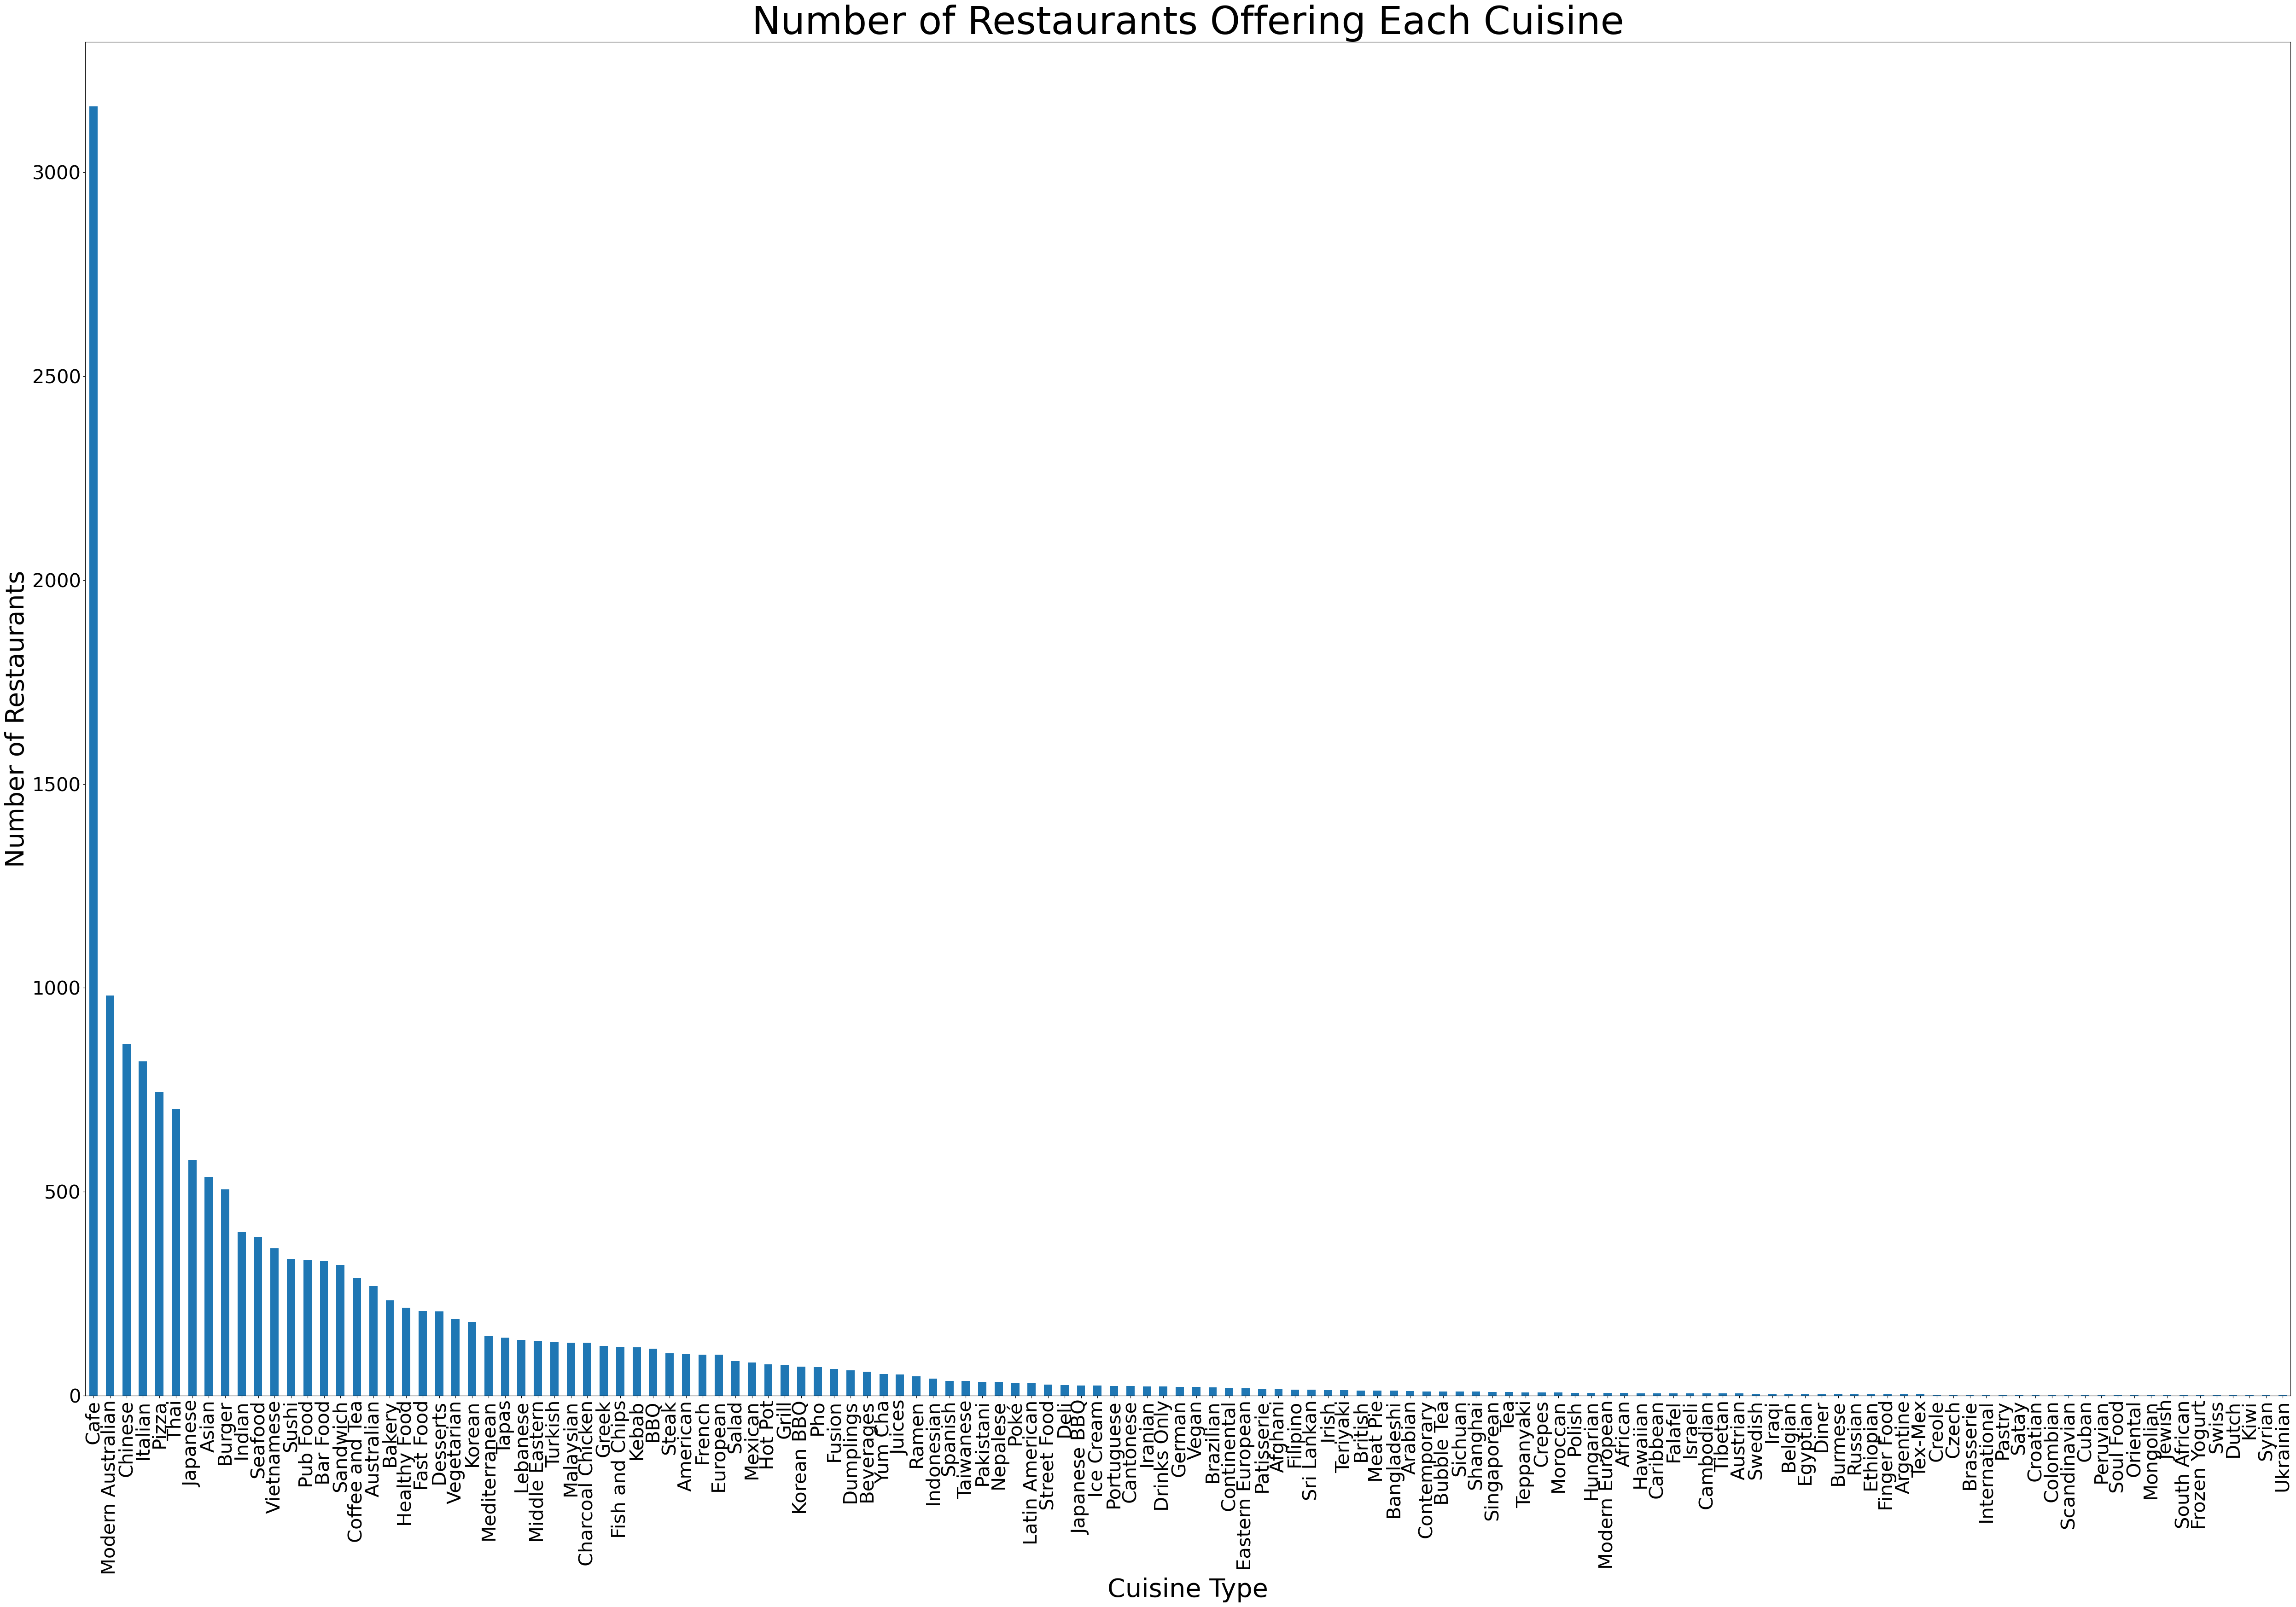

In [10]:
plt.figure(figsize=(50, 35))
count.plot(kind='bar')
plt.title('Number of Restaurants Offering Each Cuisine',fontsize=60)
plt.xlabel('Cuisine Type',fontsize=40)
plt.ylabel('Number of Restaurants',fontsize=40)
plt.xticks(rotation=90, fontsize=30) 
plt.yticks(fontsize=30)
plt.tight_layout()

# Display the plot
plt.show()

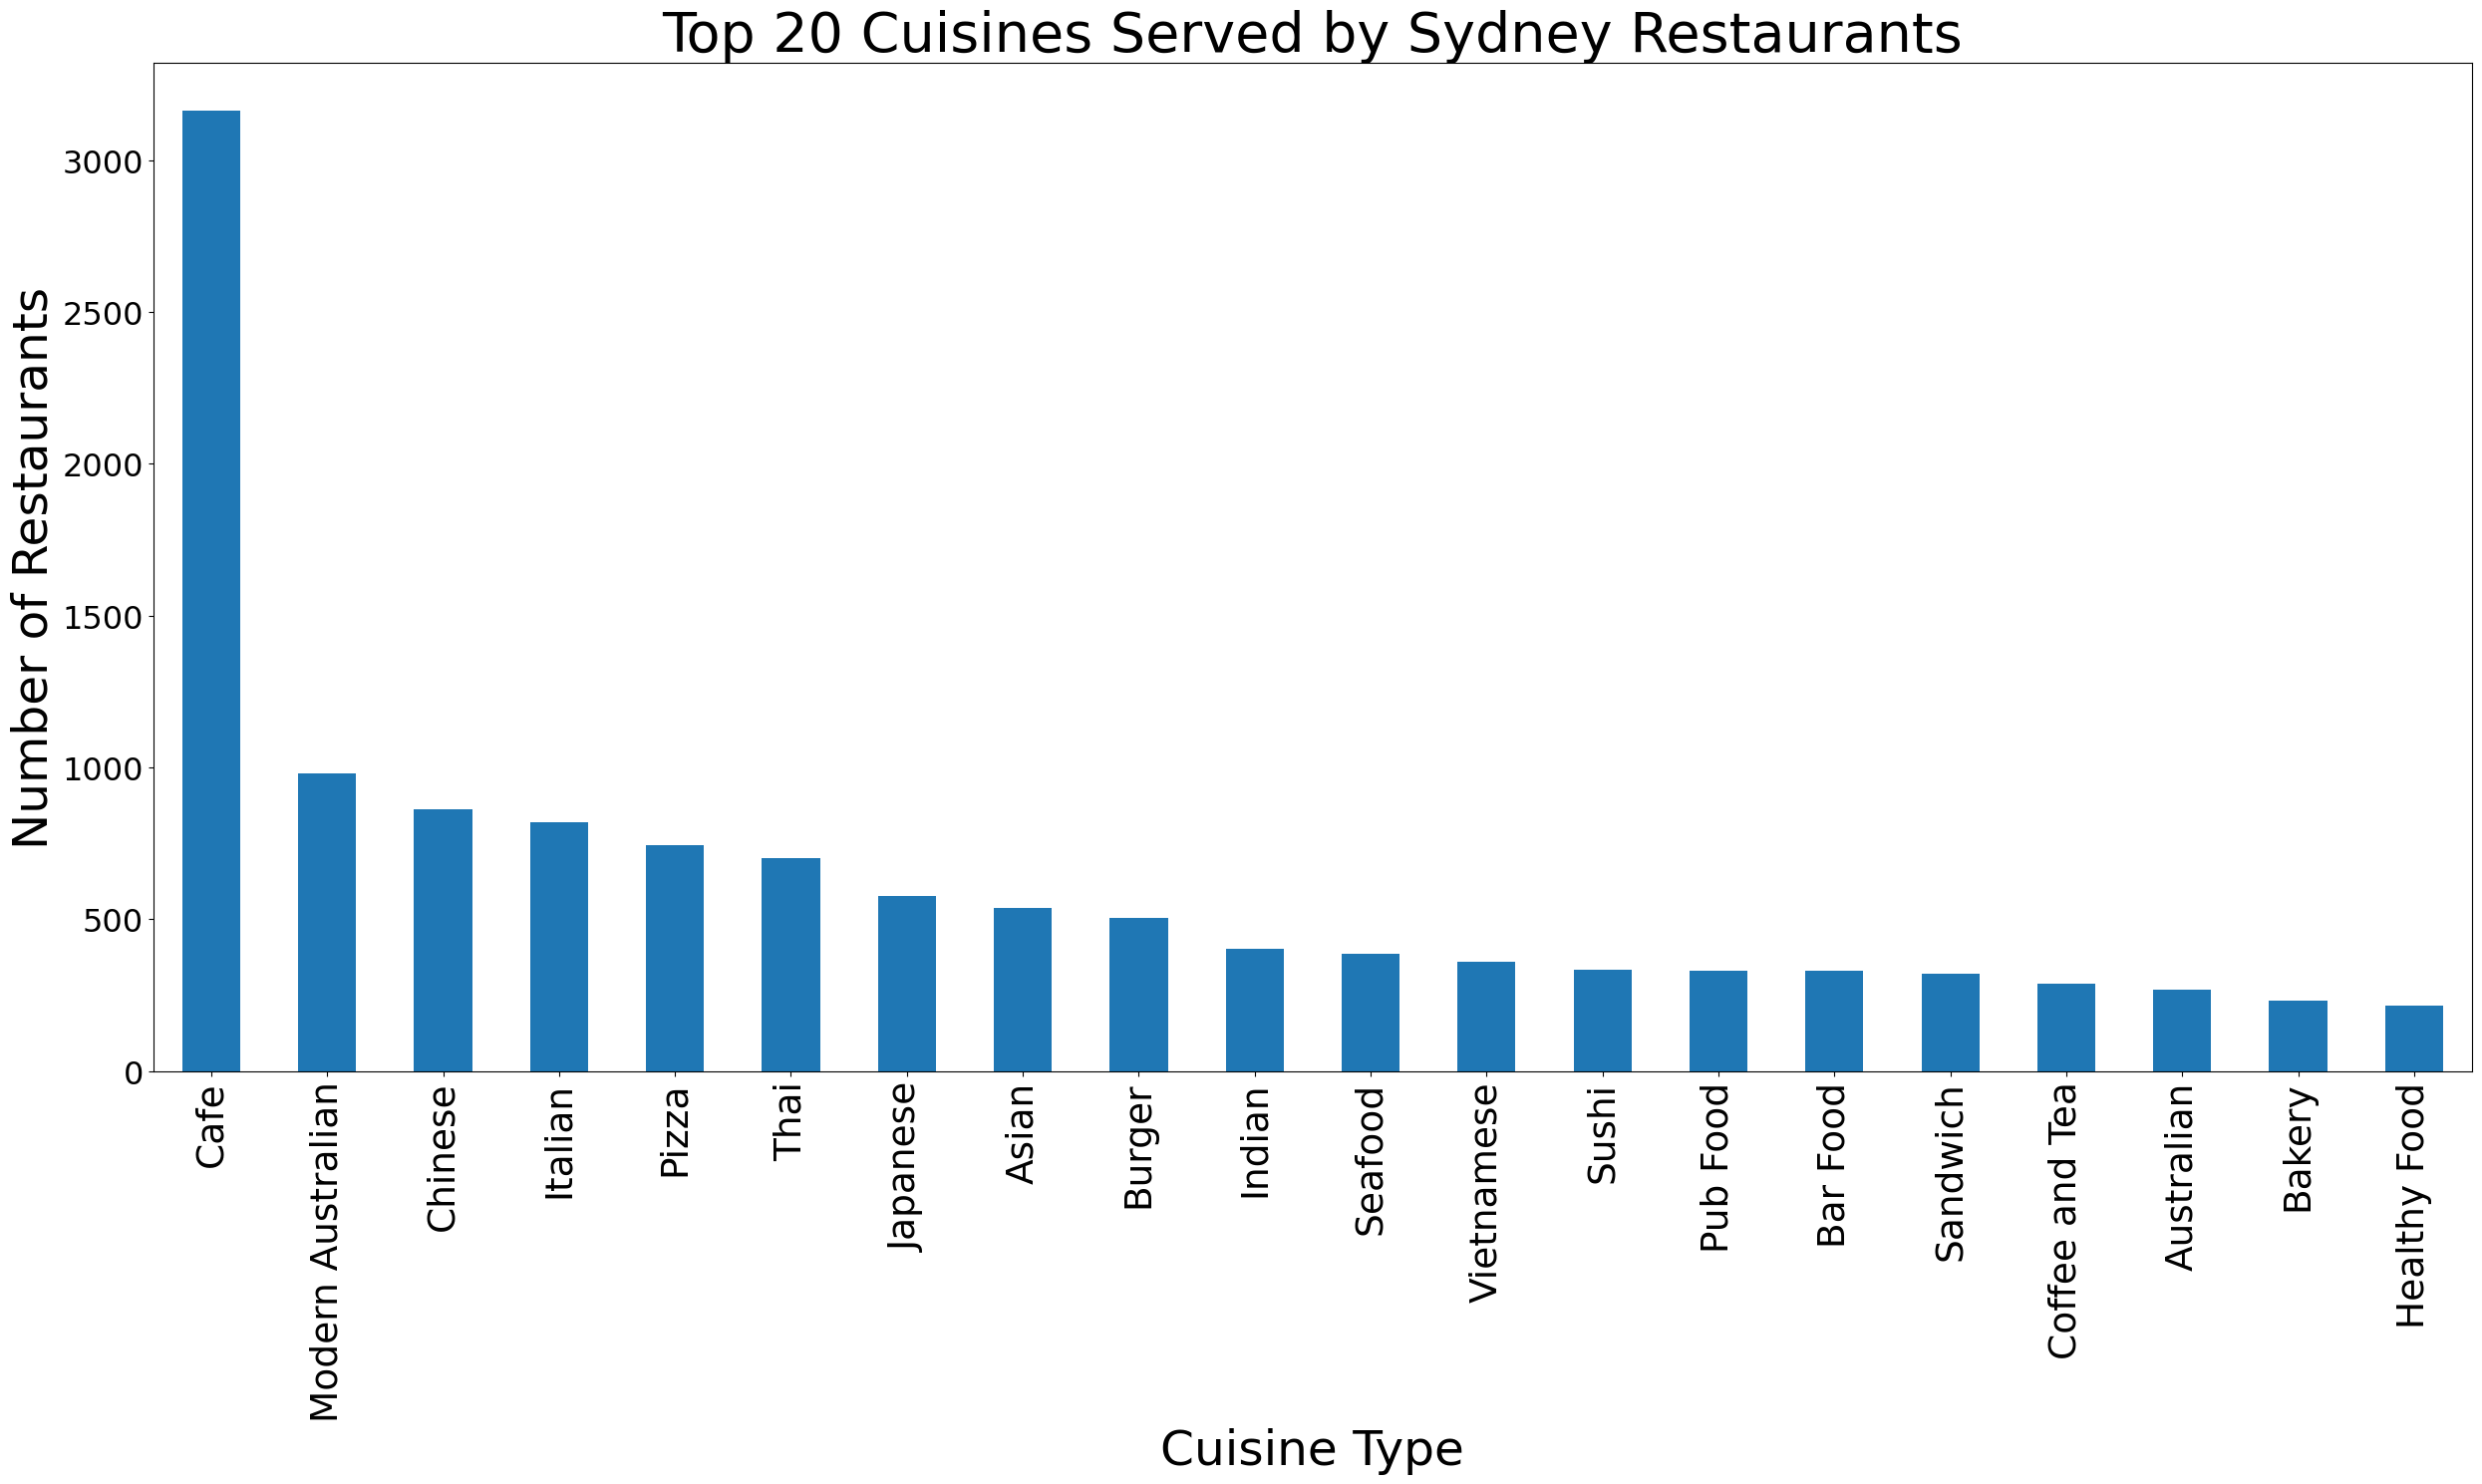

In [11]:
# Assuming `count` contains the value counts of cuisines
plt.figure(figsize=(25, 15))

# Plot the top 20 cuisines
count.head(20).plot(kind='bar')

plt.title('Top 20 Cuisines Served by Sydney Restaurants', fontsize=40)
plt.xlabel('Cuisine Type', fontsize=35)
plt.ylabel('Number of Restaurants', fontsize=35)

plt.xticks(rotation=90, fontsize=27)
plt.yticks(fontsize=23)
plt.tight_layout()

# Display the plot
plt.show()

The code sets up a figure, plots the top 20 cuisines in a bar chart, adjusts the axis labels for readability (rotation and font sizes), and ensures the layout looks good before rendering the plot. It's a clean, structured process to visualize the most common cuisines served in Sydney restaurants.


### Q1.b : Which suburbs (top 3) have the highest number of restaurants?

In [12]:
sydney_suburbs = ['Abbotsbury', 'Abbotsford', 'Acacia Gardens', 'Agnes Banks', 'Airds', 'Alexandria', 'Alfords Point', 'Allambie Heights', 'Allawah', 'Ambarvale', 'Angus', 'Annandale', 'Annangrove', 'Arcadia', 'Arncliffe', 'Arndell Park', 'Artarmon', 'Ashbury', 'Ashcroft', 'Ashfield', 'Asquith', 'Auburn', 'Austral', 'Avalon', 'Badgerys Creek', 'Balgowlah', 'Balgowlah Heights', 'Balmain', 'Balmain East', 'Bangor', 'Banksia', 'Banksmeadow', 'Bankstown', 'Bankstown Aerodrome', 'Barangaroo', 'Barden Ridge', 'Bardia', 'Bardwell Park', 'Bardwell Valley', 'Bass Hill', 'Baulkham Hills', 'Bayview', 'Beacon Hill', 'Beaconsfield', 'Beaumont Hills', 'Beecroft', 'Belfield', 'Bella Vista', 'Bellevue Hill', 'Belmore', 'Belrose', 'Berala', 'Berkshire Park', 'Berowra', 'Berowra Heights', 'Berowra Waters', 'Berrilee', 'Beverley Park', 'Beverly Hills', 'Bexley', 'Bexley North', 'Bidwill', 'Bilgola Beach', 'Bilgola Plateau', 'Birchgrove', 'Birrong', 'Blackett', 'Blacktown', 'Blair Athol', 'Blairmount', 'Blakehurst', 'Bligh Park', 'Bondi', 'Bondi Beach', 'Bondi Junction', 'Bonnet Bay', 'Bonnyrigg', 'Bonnyrigg Heights', 'Bossley Park', 'Botany', 'Bow Bowing', 'Box Hill', 'Bradbury', 'Bradfield', 'Breakfast Point', 'Brighton-Le-Sands', 'Bringelly', 'Bronte', 'Brooklyn', 'Brookvale', 'Bundeena', 'Bungarribee', 'Burraneer', 'Burwood', 'Burwood Heights', 'Busby', 'Cabarita', 'Cabramatta', 'Cabramatta West', 'Caddens', 'Cambridge Gardens', 'Cambridge Park', 'Camden', 'Camden South', 'Camellia', 'Cammeray', 'Campbelltown', 'Camperdown', 'Campsie', 'Canada Bay', 'Canley Heights', 'Canley Vale', 'Canoelands', 'Canterbury', 'Caringbah', 'Caringbah South', 'Carlingford', 'Carlton', 'Carnes Hill', 'Carramar', 'Carss Park', 'Cartwright', 'Castle Cove', 'Castle Hill', 'Castlecrag', 'Castlereagh', 'Casula', 'Catherine Field', 'Cattai', 'Cawdor', 'Cecil Hills', 'Cecil Park', 'Centennial Park', 'CBD', 'Central Business District', 'Chatswood', 'Chatswood West', 'Cheltenham', 'Cherrybrook', 'Chester Hill', 'Chifley', 'Chinatown', 'Chippendale', 'Chipping Norton', 'Chiswick', 'Chullora', 'Church Point', 'Claremont Meadows', 'Circular Quay', 'Clarendon', 'Clareville', 'Claymore', 'Clemton Park', 'Clontarf', 'Clovelly', 'Clyde', 'Coasters Retreat', 'Cobbitty', 'Colebee', 'Collaroy', 'Collaroy Plateau', 'Colyton', 'Como', 'Concord', 'Concord West', 'Condell Park', 'Connells Point', 'Constitution Hill', 'Coogee', 'Cornwallis', 'Cottage Point', 'Cowan', 'Cranebrook', 'Cremorne', 'Cremorne Point', 'Cromer', 'Cronulla', 'Crows Nest', 'Croydon', 'Croydon Park', 'Cumberland Reach', 'Curl Curl', 'Currans Hill', 'Currawong Beach', 'Darling Harbour', 'Daceyville', 'Dangar Island', 'Darling Point', 'Darlinghurst', 'Darlington', 'Davidson', 'Dawes Point', 'Dean Park', 'Dee Why', 'Denham Court', 'Denistone', 'Denistone East', 'Denistone West', 'Dharruk', 'Dolans Bay', 'Dolls Point', 'Doonside', 'Double Bay', 'Dover Heights', 'Drummoyne', 'Duffys Forest', 'Dulwich Hill', 'Dundas', 'Dundas Valley', 'Dural', 'Eagle Vale', 'Earlwood', 'East Gordon', 'East Hills', 'East Killara', 'East Kurrajong', 'East Lindfield', 'East Ryde', 'Eastern Creek', 'Eastgardens', 'Eastlakes', 'Eastwood', 'Ebenezer', 'Edensor Park', 'Edgecliff', 'Edmondson Park', 'Elanora Heights', 'Elderslie', 'Elizabeth Bay', 'Elizabeth Hills', 'Ellis Lane', 'Elvina Bay', 'Emerton', 'Emu Heights', 'Emu Plains', 'Enfield', 'Engadine', 'Englorie Park', 'Enmore', 'Epping', 'Ermington', 'Erskine Park', 'Erskineville', 'Eschol Park', 'Eveleigh', 'Fairfield', 'Fairfield East', 'Fairfield Heights', 'Fairfield West', 'Fairlight', 'Fiddletown', 'Five Dock', 'Flemington', 'Forest Glen', 'Forest Lodge', 'Forestville', 'Freemans Reach', 'Frenchs Forest', 'Freshwater', 'Gables', 'Galston', 'Georges Hall', 'Gilead', 'Girraween', 'Gladesville', 'Glebe', 'Gledswood Hills', 'Glen Alpine', 'Glendenning', 'Glenfield', 'Glenhaven', 'Glenmore Park', 'Glenorie', 'Glenwood', 'Glossodia', 'Gordon', 'Grantham Farm', 'Granville', 'Grasmere', 'Grays Point', 'Great Mackerel Beach', 'Green Valley', 'Greenacre', 'Greendale', 'Greenfield Park', 'Greenhills Beach', 'Greenwich', 'Green Square', 'Gregory Hills', 'Greystanes', 'Grose Vale', 'Grose Wold', 'Guildford', 'Guildford West', 'Gymea', 'Gymea Bay', 'Haberfield', 'Hammondville', 'Harrington Park', 'Harris Park', 'Hassall Grove', 'Haymarket', 'Heathcote', 'Hebersham', 'Heckenberg', 'Henley', 'Hillsdale', 'Hinchinbrook', 'Hobartville', 'Holroyd', 'Holsworthy', 'Homebush', 'Homebush West', 'Horningsea Park', 'Hornsby', 'Hornsby Heights', 'Horsley Park', 'Hoxton Park', 'Hunters Hill', 'Huntingwood', 'Huntleys Cove', 'Huntleys Point', 'Hurlstone Park', 'Hurstville', 'Hurstville Grove', 'Illawong', 'Ingleburn', 'Ingleside', 'Jamisontown', 'Jannali', 'Jordan Springs', 'Katoomba', 'Kangaroo Point', 'Kareela', 'Kearns', 'Kellyville', 'Kellyville Ridge', 'Kemps Creek', 'Kensington', 'Kenthurst', 'Kentlyn', 'Killara', 'Killarney Heights', 'Kings Langley', 'Kings Park', 'Kingsford', 'Kingsgrove', 'Kingswood', 'Kingswood Park', 'Kirkham', 'Kirrawee', 'Kirribilli', 'Kogarah', 'Kogarah Bay', 'Ku-ring-gai Chase', 'Kurmond', 'Kurnell', 'Kurraba Point', 'Kurrajong', 'Kurrajong Hills', 'Kyeemagh', 'Kyle Bay', 'La Perouse', 'Lakemba', 'Lalor Park', 'Lane Cove', 'Lane Cove North', 'Lane Cove West', 'Lansdowne', 'Lansvale', 'Laughtondale', 'Lavender Bay', 'Leets Vale', 'Leichhardt', 'Len Waters Estate', 'Leonay', 'Leppington', 'Lethbridge Park', 'Leumeah', 'Lewisham', 'Liberty Grove', 'Lidcombe', 'Leura', 'Lilli Pilli', 'Lilyfield', 'Lindfield', 'Linley Point', 'Little Bay', 'Liverpool', 'Llandilo', 'Loftus', 'Londonderry', 'Long Point', 'Longueville', 'Lovett Bay', 'Lower Portland', 'Lucas Heights', 'Luddenham', 'Lugarno', 'Lurnea', 'Macquarie Fields', 'Macquarie Links', 'Macquarie Park', 'Maianbar', 'Malabar', 'Manly', 'Manly Vale', 'Maraylya', 'Marayong', 'Maroota', 'Maroubra', 'Marrickville', 'Marsden Park', 'Marsfield', 'Mascot', 'Matraville', 'Mays Hill', 'McCarrs Creek', 'McGraths Hill', 'McMahons Point', 'Meadowbank', 'Melonba', 'Melrose Park', 'Menai', 'Menangle Park', 'Merrylands', 'Merrylands West', 'Middle Cove', 'Middle Dural', 'Middleton Grange', 'Miller', 'Millers Point', 'Milperra', 'Milsons Passage', 'Milsons Point', 'Minchinbury', 'Minto', 'Minto Heights', 'Miranda', 'Mona Vale', 'Monterey', 'Moore Park', 'Moorebank', 'Morning Bay', 'Mortdale', 'Mortlake', 'Mosman', 'Mount Annan', 'Mount Colah', 'Mount Druitt', 'Mount Kuring-Gai', 'Mount Lewis', 'Mount Pritchard', 'Mount Vernon', 'Mulgoa', 'Mulgrave', 'Narellan', 'Narellan Vale', 'Naremburn', 'Narrabeen', 'Narraweena', 'Narwee', 'Nelson', 'Neutral Bay', 'Newington', 'Newport', 'Newtown', 'Nirimba Fields', 'Normanhurst', 'North Balgowlah', 'North Bondi', 'North Curl Curl', 'North Epping', 'North Kellyville', 'North Manly', 'North Narrabeen', 'North Parramatta', 'North Richmond', 'North Rocks', 'North Ryde', 'North St Ives', 'North St Marys', 'North Strathfield', 'North Sydney', 'North Turramurra', 'North Wahroonga', 'North Willoughby', 'Northbridge', 'Northmead', 'Northwood', 'Norwest', 'Oakhurst', 'Oakville', 'Oatlands', 'Oatley', 'Old Guildford', 'Old Toongabbie', 'Oran Park', 'Orchard Hills', 'Oxford Falls', 'Oxley Park', 'Oyster Bay', 'Paddington', 'Padstow', 'Padstow Heights', 'Pagewood', 'Palm Beach', 'Panania', 'Parklea', 'Parramatta', 'Peakhurst', 'Peakhurst Heights', 'Pemulwuy', 'Pendle Hill', 'Pennant Hills', 'Penrith', 'Penshurst', 'Petersham', 'Phillip Bay', 'Picnic Point', 'Pitt Town', 'Pitt Town Bottoms', 'Pleasure Point', 'Plumpton', 'Point Piper', 'Port Botany', 'Port Hacking', 'Potts Hill', 'Potts Point', 'Prairiewood', 'Prestons', 'Prospect', 'Punchbowl', 'Putney', 'Pymble', 'Pyrmont', 'Quakers Hill', 'Queens Park', 'Queenscliff', 'Raby', 'Ramsgate', 'Ramsgate Beach', 'Randwick', 'Redfern', 'Regents Park', 'Regentville', 'Revesby', 'Revesby Heights', 'Rhodes', 'Richmond', 'Richmond Lowlands', 'Riverstone', 'Riverview', 'Riverwood', 'Rockdale', 'Rodd Point', 'Rookwood', 'Rooty Hill', 'Ropes Crossing', 'Rose Bay', 'Rosebery', 'Rosehill', 'Roselands', 'Rosemeadow', 'Roseville', 'Roseville Chase', 'Rossmore', 'Rouse Hill', 'Royal National Park', 'Rozelle', 'Ruse', 'Rushcutters Bay', 'Russell Lea', 'Rydalmere', 'Ryde', 'Sackville', 'Sackville North', 'Sadleir', 'Sandringham', 'Sandy Point', 'Sans Souci', 'Scheyville', 'Schofields', 'Scotland Island', 'Seaforth', 'Sefton', 'Seven Hills', 'Shalvey', 'Shanes Park', 'Silverwater', 'Singletons Mill', 'Smeaton Grange', 'Smithfield', 'South Coogee', 'South Granville', 'South Hurstville', 'South Maroota', 'South Penrith', 'South Turramurra', 'South Wentworthville', 'South Windsor', 'Spring Farm', 'St Andrews', 'St Clair', 'St Helens Park', 'St Ives', 'Sydney Airport', 'St Ives Chase', 'St James', 'St Johns Park', 'St Leonards', 'St Marys', 'St. Peters', 'Stanhope Gardens', 'Stanmore', 'Strathfield', 'Strathfield South', 'Summer Hill', 'Surry Hills', 'Sutherland', 'Sydenham', 'Sydney Olympic Park', 'Sylvania', 'Sylvania Waters', 'Tallawong', 'Tamarama', 'Taren Point', 'Telopea', 'Tempe', 'Tennyson', 'Tennyson Point', 'Terrey Hills', 'The Ponds', 'The Rocks', 'The Slopes', 'Thornleigh', 'Toongabbie', 'Tregear', 'Turramurra', 'Turrella', 'Ultimo', 'Varroville', 'Vaucluse', 'Villawood', 'Vineyard', 'Voyager Point', 'Wahroonga', 'Waitara', 'Wakeley', 'Wallacia', 'Wareemba', 'Warrawee', 'Warriewood', 'Warwick Farm', 'Waterfall', 'Waterloo', 'Watsons Bay', 'Wattle Grove', 'Waverley', 'Waverton', 'Wedderburn', 'Wentworth Point', 'Wentworthville', 'Werrington', 'Werrington County', 'Werrington Downs', 'West Hoxton', 'West Killara', 'West Pennant Hills', 'West Pymble', 'West Ryde', 'Westleigh', 'Westmead', 'Wetherill Park', 'Whalan', 'Whale Beach', 'Wheeler Heights', 'Wilberforce', 'Wiley Park', 'Willmot', 'Willoughby', 'Willoughby East', 'Windsor', 'Windsor Downs', 'Winston Hills', 'Wisemans Ferry', 'Wolli Creek', 'Wollstonecraft', 'Woodbine', 'Woodcroft', 'Woodpark',
                  'Woollahra', 'Woolloomooloo', 'Woolooware', 'Woolwich', 'Woronora', 'Woronora Heights', 'Wynyard', 'Yagoona', 'Yarramundi', 'Yarrawarrah', 'Yennora', 'Yowie Bay','Zetland']

In [13]:
# Iterate through the dataframe and update the 'suburb' column
suburbs = []

for index, row in df.iterrows():
    # Initiate the suburb to the value of subzone
    suburb = row['subzone']
    
    # Loop through each suburb in the suburbs list
    for suburb_name in sydney_suburbs:
        # Check if the suburb name is in 'subzone' or 'address'
        if suburb_name in row['subzone'] or suburb_name in row['address']:
            suburb = suburb_name
            break  # break the loop
    
    # Append the result to the suburbs_column list
    suburbs.append(suburb)

# Add the result to the dataframe
df['suburb'] = suburbs

In [14]:
df['suburb'] = df['suburb'].replace('Wooloware', 'Woolooware')

In [15]:
df['suburb'].nunique()

361

Since the column Subzone doesn't contain the real suburbs name we clean and standardizes the 'suburb' column by identifying and extracting the correct suburb names from the 'subzone' or 'address' columns, and then updates the DataFrame with the cleaned values.


In [16]:
suburb_count = df['suburb'].value_counts()


In [17]:
top_suburbs = suburb_count.head(3)

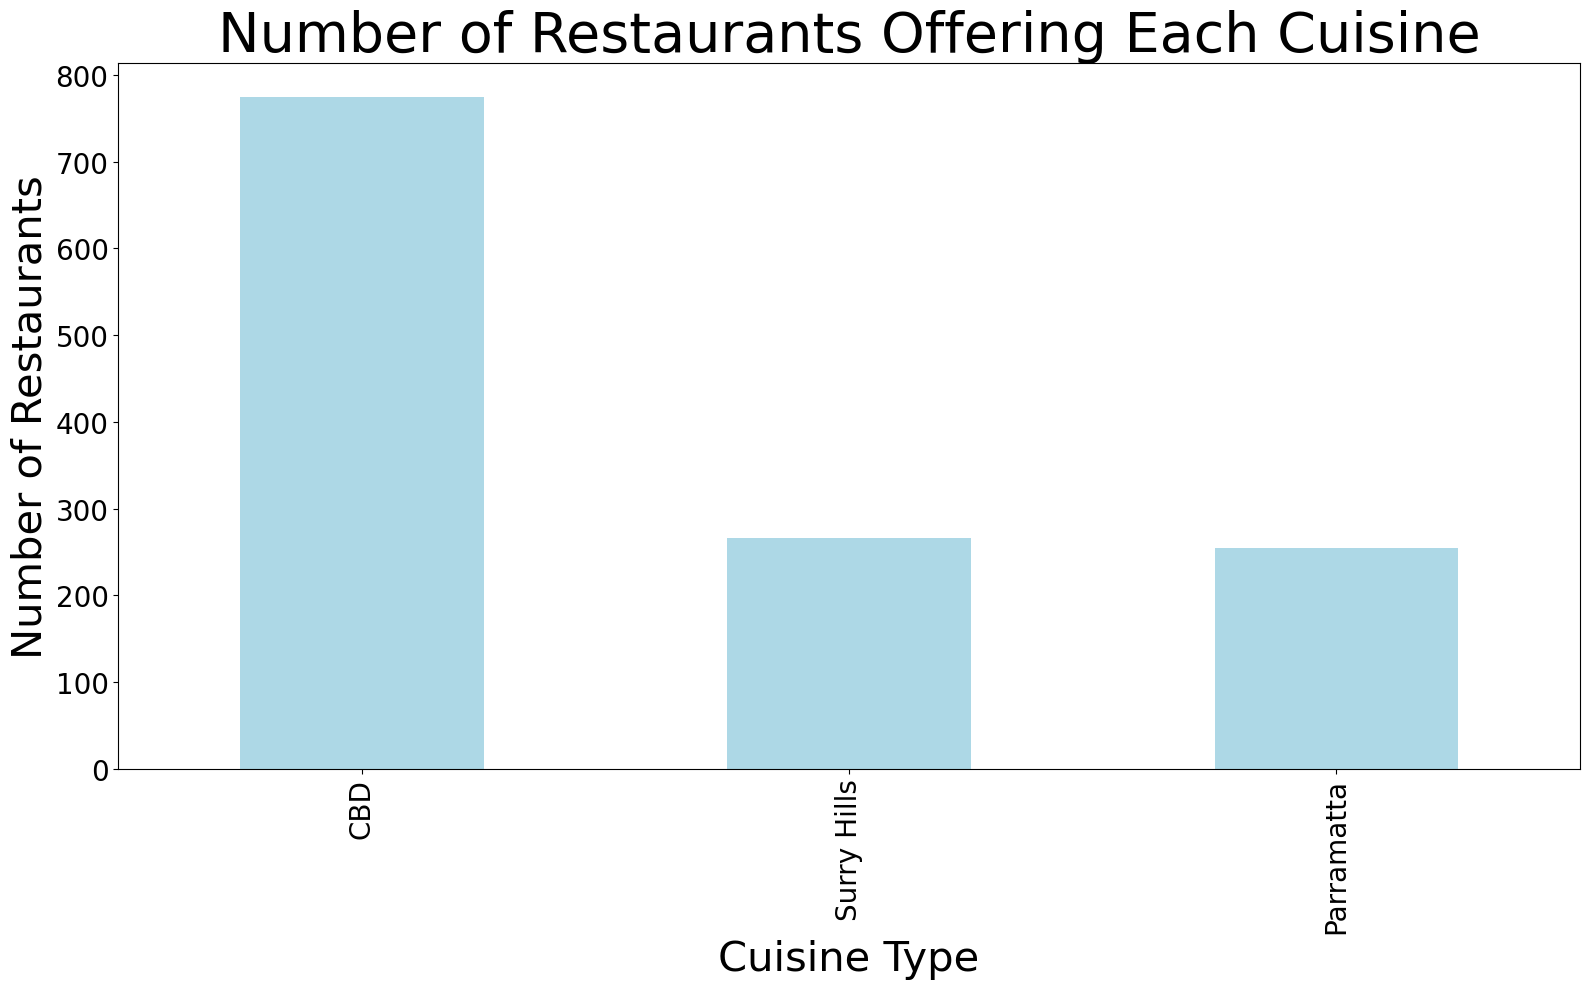

In [18]:
# Plot a bar graph of the counts of each cuisine
plt.figure(figsize=(16, 10))
top_suburbs.plot(kind='bar',color = '#ADD8E6')
plt.title('Number of Restaurants Offering Each Cuisine', fontsize=40)
plt.xlabel('Cuisine Type',fontsize=30)
plt.ylabel('Number of Restaurants',fontsize=30)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

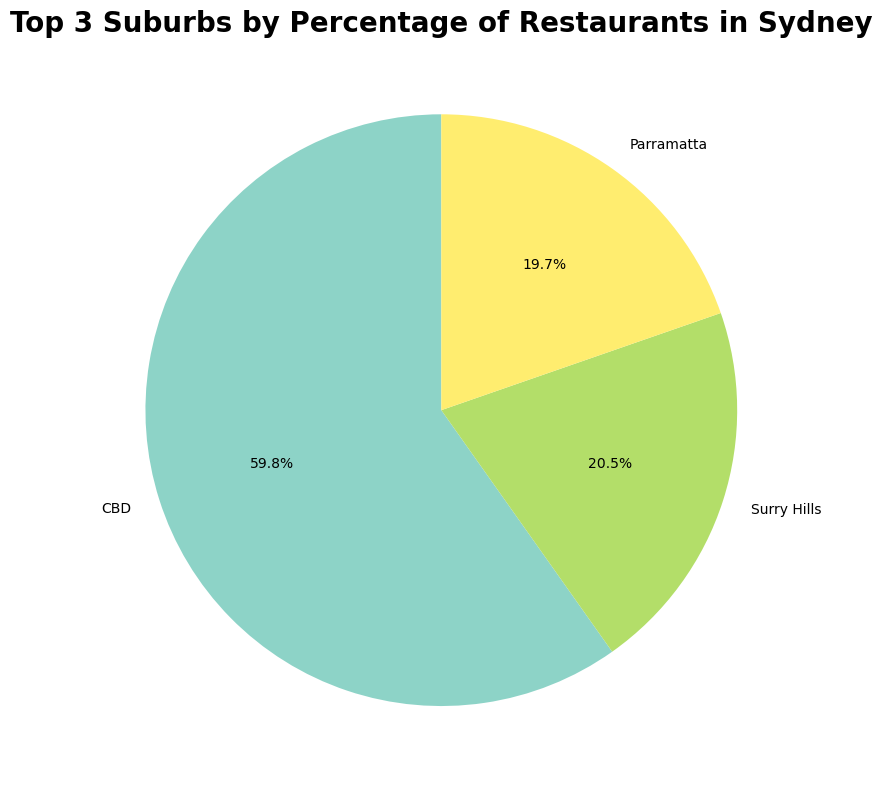

In [19]:
# Plot a pie chart for the top 5 suburbs
plt.figure(figsize=(8, 8))
top_suburbs.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3' )

# Customize title and remove ylabel
plt.title("Top 3 Suburbs by Percentage of Restaurants in Sydney", fontsize=20, fontweight='bold')
plt.ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

This code creates a pie chart displaying the top suburbs based on the percentage of restaurants and adjusts the formatting for clear readability.


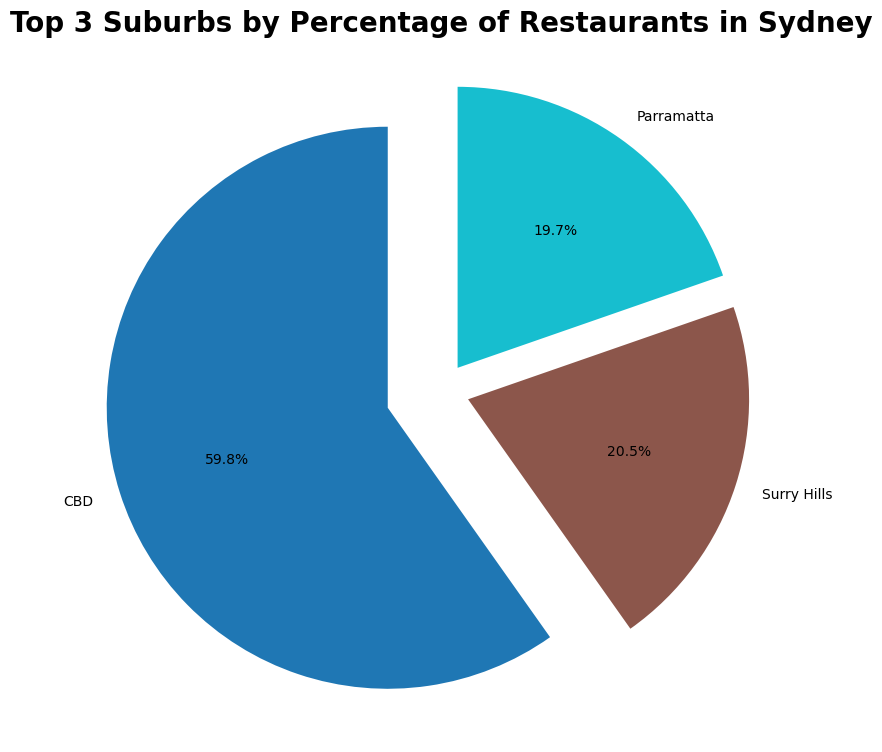

In [20]:


# Plot a pie chart for the top 5 suburbs
plt.figure(figsize=(8, 8))
explode=[0.2] + [0.1]*2
top_suburbs.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab10', explode= explode )

# Customize title and remove ylabel
plt.title("Top 3 Suburbs by Percentage of Restaurants in Sydney", fontsize=20, fontweight='bold')
plt.ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

This code generates a pie chart with separated slices to emphasize specific suburbs and adjusts the appearance for enhanced clarity and readability.


In [21]:
# Group the data by 'rating_text' and calculate the median cost for each rating
cost_by_rating = df.groupby('rating_text')['cost'].median().sort_index()

print(cost_by_rating)

rating_text
Average      45.0
Excellent    60.0
Good         50.0
Poor         50.0
Very Good    60.0
Name: cost, dtype: float64


### Q1.c: Restaurants with ‘excellent’ ratings are mostly costly while those with ‘Poor’
ratings are rarely expensive”. Do you agree with this statement or not? Please
support your answer with numbers and visuals. 

In [22]:
def categorize_cost(cost):
    if cost <= 20:
        return 'Low'
    elif 20 < cost <= 50:
        return 'Medium'
    elif 50 < cost <= 100:
        return 'High'
    elif 100 < cost <= 200:
        return 'Very High'
    else:
        return 'Expensive'

In [23]:
df['cost_category'] = df['cost'].apply(categorize_cost)

In [24]:
# Create a subset with only 'cost_category' and 'rating_text'
df_subset = df[['cost_category', 'rating_text']]

In [25]:
# Count the number of restaurants for each combination of cost category and rating
cost_vs_rating_counts = df_subset.groupby(['rating_text', 'cost_category']).size().unstack(fill_value=0)

In [26]:
# Calculate the percentage
cost_vs_rating_percent = cost_vs_rating_counts.div(cost_vs_rating_counts.sum(axis=1), axis=0) * 100

# Print the percentage table 
print(cost_vs_rating_percent)

cost_category  Expensive       High       Low     Medium  Very High
rating_text                                                        
Average         1.799600  33.103755  4.399022  58.253721   2.443901
Excellent       9.803922  31.372549  9.803922  31.372549  17.647059
Good            1.095462  42.097027  1.930099  48.774126   6.103286
Poor            3.827751  39.234450  1.913876  52.153110   2.870813
Very Good       2.173913  47.035573  1.383399  37.747036  11.660079


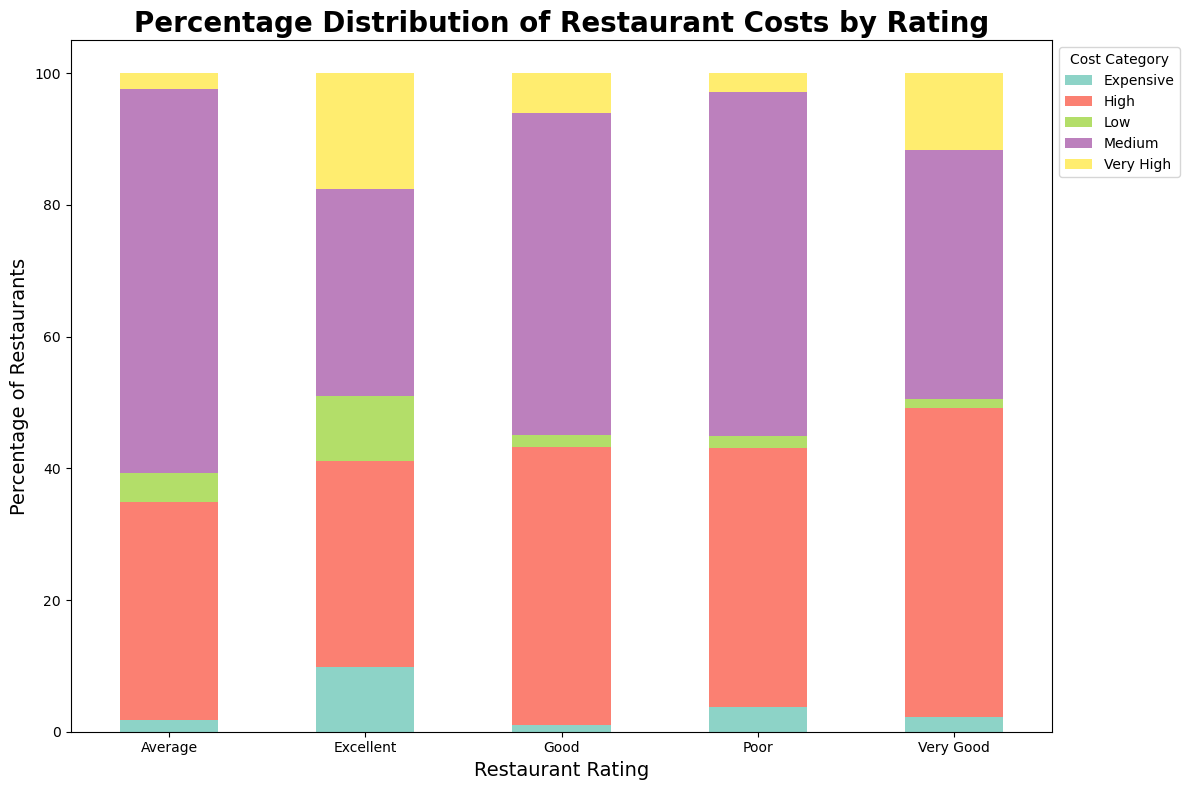

In [27]:
#Plot Cost Vs Ratings
cost_vs_rating_percent.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set3')
plt.title('Percentage Distribution of Restaurant Costs by Rating', fontsize=20, fontweight='bold')
plt.xlabel('Restaurant Rating', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)
plt.legend(title="Cost Category", loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)  
plt.tight_layout()  

# Display the plot
plt.show()

- The stacked bar chart shows the proportion of restaurants within each rating category (Poor, Average, Good, Very Good, and Excellent) and how the cost categories are distributed within each.

- Excellent rated restaurants have a highest percentage of Expensive and Very High cost restaurants, confirming the statement that most excellent-rated restaurants are costly. 

- But majority of poor-rated restaurants actually falls into the Medium and High cost categories and are not necessarily the cheapest. only 1.9% of poor rated restaurants are Low cost and almost 90% of Poor rated restaurants fall in Medium/ HIgh cost category.

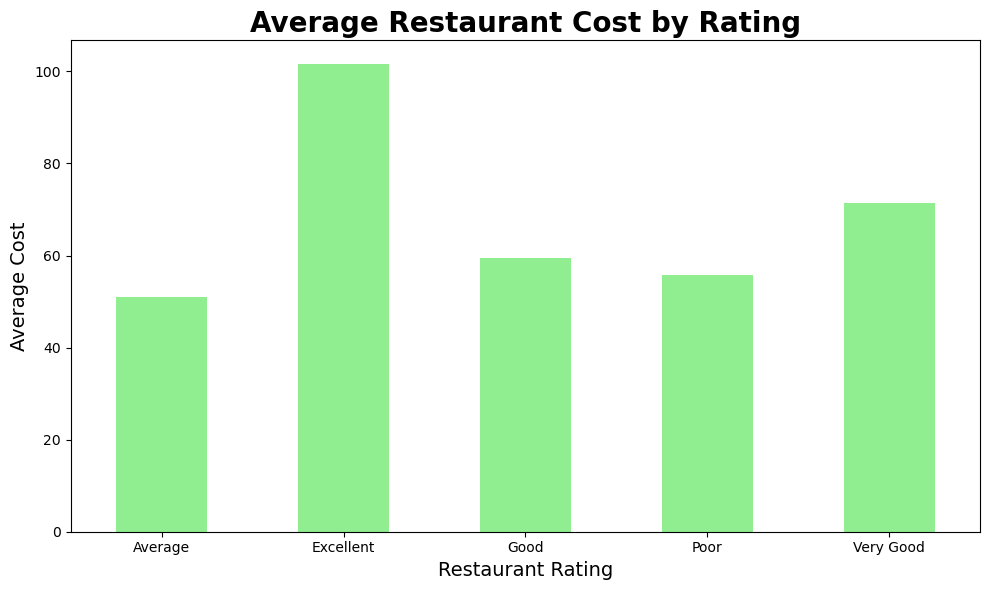

In [28]:

df_cost_ratings = df[['cost', 'rating_text']].dropna()

plt.figure(figsize=(10, 6))
df_cost_ratings.groupby('rating_text')['cost'].mean().plot(kind='bar', color='lightgreen')

plt.title('Average Restaurant Cost by Rating', fontsize=20, fontweight='bold')
plt.xlabel('Restaurant Rating', fontsize=14)
plt.ylabel('Average Cost', fontsize=14)
plt.xticks(rotation=0)  
plt.tight_layout()

# Display the plot
plt.show()

- Excellent rated restaurants have the highest average cost.
- Poor rated restaurants have a lower average cost compared to all of the categories other than Average, which has the lowest average cost.

In [29]:
# Calculate the average rating for each cost category
average_rating_by_cost = df.groupby('cost_category')['rating_number'].mean()

print(average_rating_by_cost)

cost_category
Expensive    3.245238
High         3.349070
Low          3.155777
Medium       3.226543
Very High    3.569435
Name: rating_number, dtype: float64


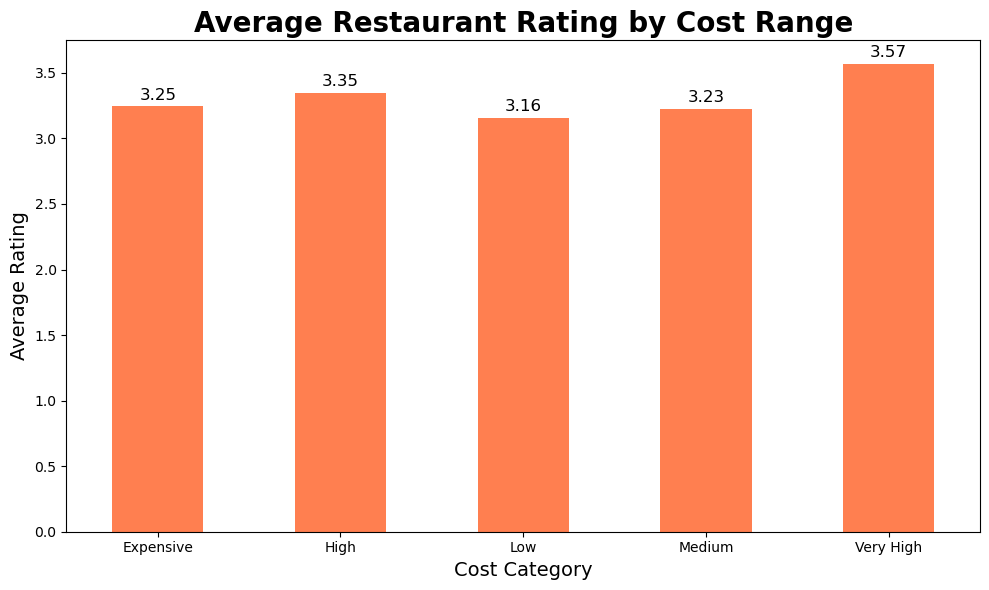

In [30]:
plt.figure(figsize=(10, 6))
bars = average_rating_by_cost.plot(kind='bar', color='coral')

plt.title('Average Restaurant Rating by Cost Range', fontsize=20, fontweight='bold')
plt.xlabel('Cost Category', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=0)  # Ensure labels are horizontal for readability
plt.tight_layout()
for i, value in enumerate(average_rating_by_cost):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', fontsize=12)

plt.show()

### Answer: 
- ***Excellent-rated restaurants*** tend to be more expensive, with significant percentage of Excellent restaurants fall in the Expensive and Very High cost categories.
- ***Poor-rated restaurants*** have significant representation in the High and Medium cost categories, so the assumption that they are rarely expensive is incorrect. 

## Q2:  EDA

In [31]:
# data shape
print("Shape of the dataset:", df.shape)

# column names
print("Columns in the dataset:", df.columns)

Shape of the dataset: (10500, 21)
Columns in the dataset: Index(['address', 'cost', 'cuisine', 'lat', 'link', 'lng', 'phone',
       'rating_number', 'rating_text', 'subzone', 'title', 'type', 'votes',
       'groupon', 'color', 'cost_2', 'cuisine_color', 'cuisine1', 'type1',
       'suburb', 'cost_category'],
      dtype='object')


In the original datatset there were 17 columns and we added another one named suburb.

In [32]:
# Data types of each column
print("Data types of columns:\n", df.dtypes)

Data types of columns:
 address           object
cost             float64
cuisine           object
lat              float64
link              object
lng              float64
phone             object
rating_number    float64
rating_text       object
subzone           object
title             object
type              object
votes            float64
groupon             bool
color             object
cost_2           float64
cuisine_color     object
cuisine1          object
type1             object
suburb            object
cost_category     object
dtype: object


In [33]:
print(df.describe())

               cost           lat           lng  rating_number        votes  \
count  10154.000000  10308.000000  10308.000000    7184.000000  7184.000000   
mean      51.153240    -32.921377    148.067359       3.283672    83.581013   
std       27.799485      8.263449     26.695402       0.454580   175.117966   
min        8.000000    -37.858473   -123.270371       1.800000     4.000000   
25%       30.000000    -33.899094    151.061061       3.000000    12.000000   
50%       45.000000    -33.872741    151.172468       3.300000    32.000000   
75%       60.000000    -33.813451    151.208940       3.600000    87.000000   
max      500.000000     51.500986    152.869052       4.900000  3236.000000   

             cost_2  
count  10154.000000  
mean       5.332974  
std        2.147115  
min        2.000000  
25%        3.699187  
50%        4.857724  
75%        6.016260  
max       40.000000  


In [34]:
# Check for missing values
print(df.isna().sum())

address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
cuisine1            0
type1              48
suburb              0
cost_category       0
dtype: int64


In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        10500 non-null  object 
 1   cost           10154 non-null  float64
 2   cuisine        10500 non-null  object 
 3   lat            10308 non-null  float64
 4   link           10500 non-null  object 
 5   lng            10308 non-null  float64
 6   phone          10500 non-null  object 
 7   rating_number  7184 non-null   float64
 8   rating_text    7184 non-null   object 
 9   subzone        10500 non-null  object 
 10  title          10500 non-null  object 
 11  type           10452 non-null  object 
 12  votes          7184 non-null   float64
 13  groupon        10500 non-null  bool   
 14  color          10500 non-null  object 
 15  cost_2         10154 non-null  float64
 16  cuisine_color  10500 non-null  object 
 17  cuisine1       10500 non-null  object 
 18  type1 

In [36]:
# types of variables
# categrical variables
categorical = [var for var in df.columns if df[var].dtype=='object']
print("There are {} categorical variables\n".format(len(categorical)))
print("The categorical variables are: ", categorical)

There are 14 categorical variables

The categorical variables are:  ['address', 'cuisine', 'link', 'phone', 'rating_text', 'subzone', 'title', 'type', 'color', 'cuisine_color', 'cuisine1', 'type1', 'suburb', 'cost_category']


### Explore categorical variables


In [37]:
# Explore categorical variables
df[categorical].head()

address  \
0                      371A Pitt Street, CBD, Sydney   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   
2   Level G, The Darling at the Star, 80 Pyrmont ...   
3   Sydney Opera House, Bennelong Point, Circular...   
4              20 Campbell Street, Chinatown, Sydney   

                                       cuisine  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké']   
2                                 ['Japanese']   
3                        ['Modern Australian']   
4                            ['Thai', 'Salad']   

                                                link         phone  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  02 8318 0406   
1  https://www.zomato.com/sydney/the-grounds-of-a...  02 9699 2225   
2        https://www.zomato.com/sydney/sokyo-pyrmont  1800 700 700   
3  https://www.zomato.com/sydney/bennelong-restau...  02 9240 8000   
4  https://www.zomato.com/sydney/chat-thai-chinatown  02 8317 4811   

  rating_text                                subzone  \
0   Very Good                                    CBD   
1   Excellent  The Grounds of Alexandria, Alexandria   
2   Excellent                      The Star, Pyrmont   
3   Excellent                          Circular Quay   
4   Excellent                              Chinatown   

                            title                    type    color  \
0                   Sydney Madang       ['Casual Dining']  #e15307   
1  The Grounds of Alexandria Cafe                ['Café']  #9c3203   
2                           Sokyo         ['Fine Dining']  #7f2704   
3            Bennelong Restaurant  ['Fine Dining', 'Bar']  #7f2704   
4                       Chat Thai       ['Casual Dining']  #a83703   

  cuisine_color                             cuisine1               type1  \
0       #6f706b   [Hot Pot, Korean BBQ, BBQ, Korean]     [Casual Dining]   
1       #6f706b  [Cafe, Coffee and Tea, Salad, Poké]              [Café]   
2       #6f706b                           [Japanese]       [Fine Dining]   
3       #4186f4                  [Modern Australian]  [Fine Dining, Bar]   
4       #6f706b                        [Thai, Salad]     [Casual Dining]   

          suburb cost_category  
0            CBD        Medium  
1     Alexandria          High  
2        Pyrmont     Very High  
3  Circular Quay     Expensive  
4      Chinatown          High

In [38]:
# check missing variables
print(df[categorical].isnull().sum())
print("********\nPercentages of missing values\n********")
print(100 * df[categorical].isnull().sum() / df.shape[0])

address             0
cuisine             0
link                0
phone               0
rating_text      3316
subzone             0
title               0
type               48
color               0
cuisine_color       0
cuisine1            0
type1              48
suburb              0
cost_category       0
dtype: int64
********
Percentages of missing values
********
address           0.000000
cuisine           0.000000
link              0.000000
phone             0.000000
rating_text      31.580952
subzone           0.000000
title             0.000000
type              0.457143
color             0.000000
cuisine_color     0.000000
cuisine1          0.000000
type1             0.457143
suburb            0.000000
cost_category     0.000000
dtype: float64


In [39]:
# check which of these variables has missing values?
cat_with_missing = [var for var in categorical if df[var].isnull().sum() > 0]
print(df[cat_with_missing].isnull().sum())

rating_text    3316
type             48
type1            48
dtype: int64


### Explore Numerical Variables

In [40]:
# find numerical variables
numericals = [var for var in df.columns if df[var].dtype != 'O']
print('There are {} numerical variables\n'.format(len(numericals)))
print('The numerical variables are :', numericals)
df[numericals].head()

There are 7 numerical variables

The numerical variables are : ['cost', 'lat', 'lng', 'rating_number', 'votes', 'groupon', 'cost_2']


cost        lat         lng  rating_number   votes  groupon     cost_2
0   50.0 -33.876059  151.207605            4.0  1311.0    False   5.243902
1   80.0 -33.910999  151.193793            4.6  3236.0    False   7.560976
2  120.0 -33.867971  151.195210            4.9  1227.0    False  10.650407
3  270.0 -33.856784  151.215297            4.9   278.0    False  22.235772
4   55.0 -33.879035  151.206409            4.5  2150.0    False   5.630081

In [41]:
df[numericals].isnull().sum()

cost              346
lat               192
lng               192
rating_number    3316
votes            3316
groupon             0
cost_2            346
dtype: int64

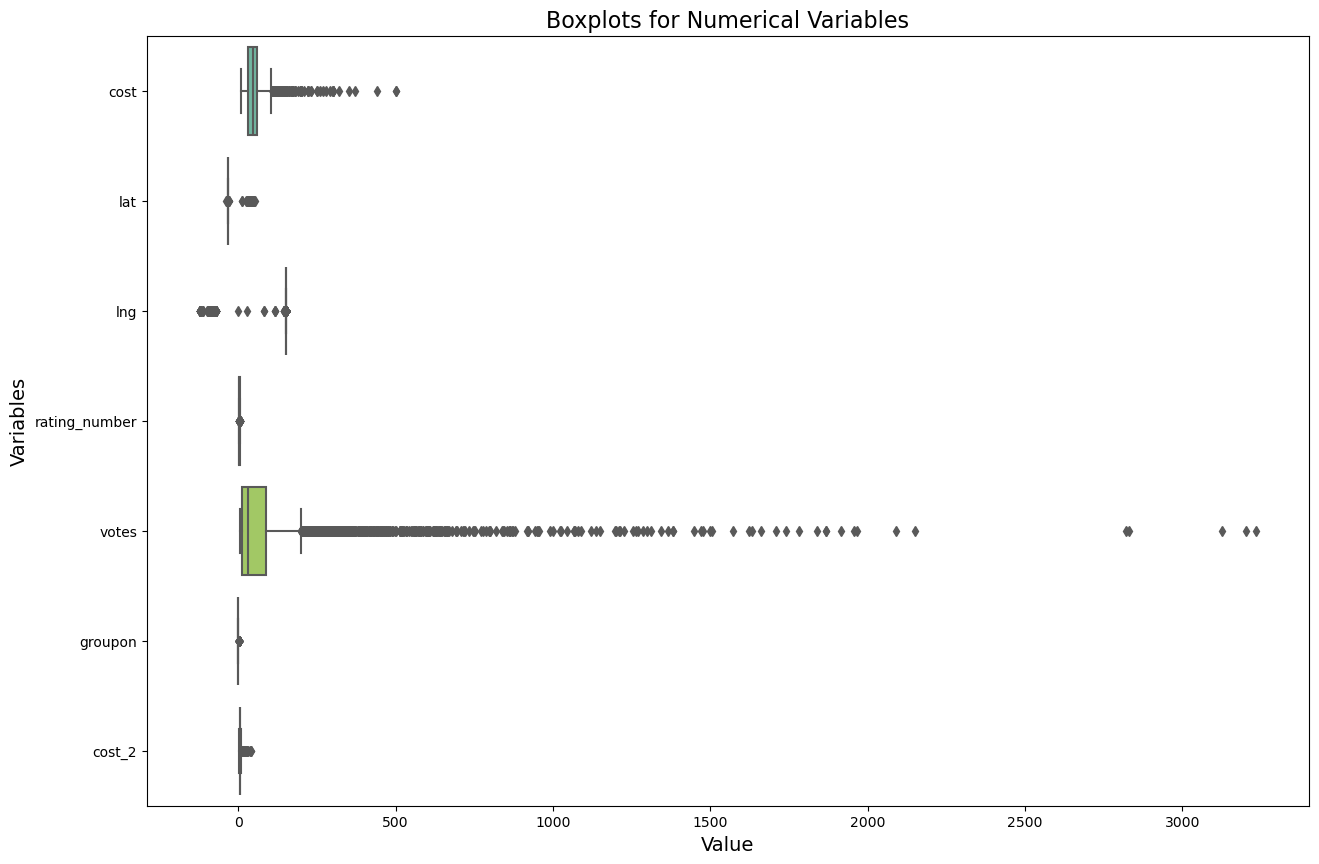

In [42]:
# boxplot of numerical column
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=df[numericals], orient="h", palette="Set2")
plt.title('Boxplots for Numerical Variables', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Variables', fontsize=14)

# Show the plot
plt.show()

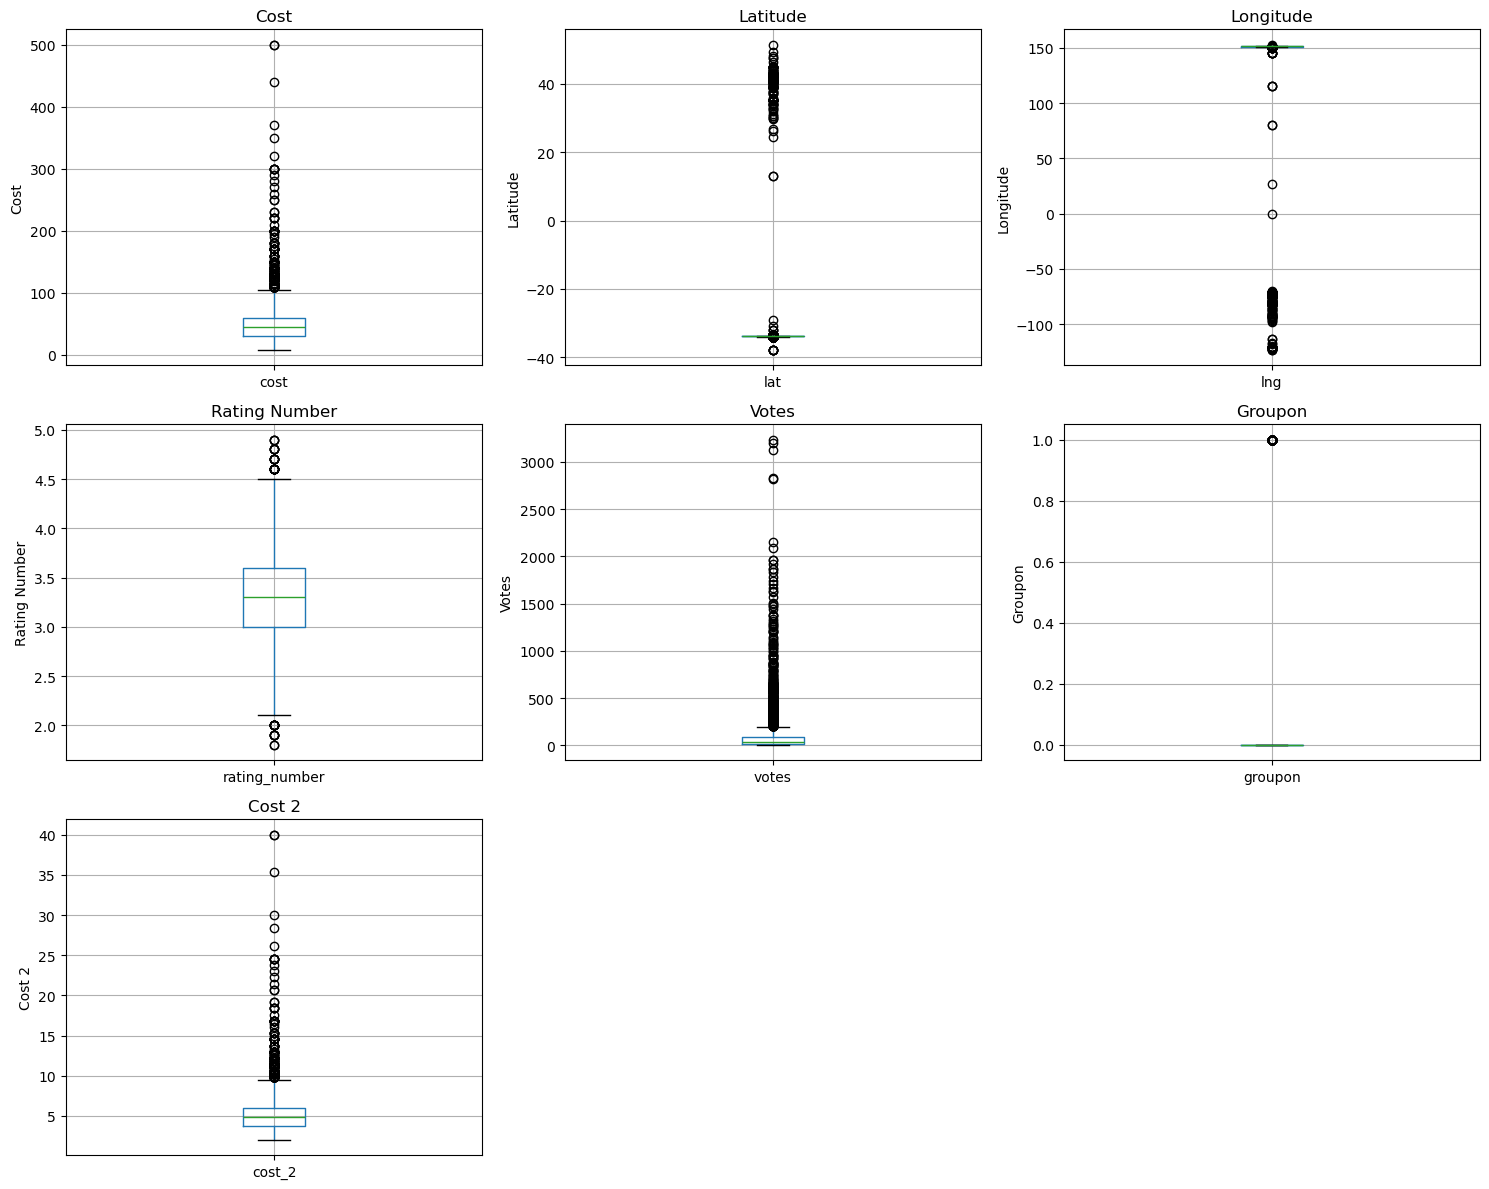

In [43]:

plt.figure(figsize=(15, 12))

# Boxplot for 'cost'
plt.subplot(3, 3, 1)
fig = df.boxplot(column='cost')
fig.set_title('Cost')
fig.set_ylabel('Cost')

# Boxplot for 'lat'
plt.subplot(3, 3, 2)
fig = df.boxplot(column='lat')
fig.set_title('Latitude')
fig.set_ylabel('Latitude')

# Boxplot for 'lng'
plt.subplot(3, 3, 3)
fig = df.boxplot(column='lng')
fig.set_title('Longitude')
fig.set_ylabel('Longitude')

# Boxplot for 'rating_number'
plt.subplot(3, 3, 4)
fig = df.boxplot(column='rating_number')
fig.set_title('Rating Number')
fig.set_ylabel('Rating Number')

# Boxplot for 'votes'
plt.subplot(3, 3, 5)
fig = df.boxplot(column='votes')
fig.set_title('Votes')
fig.set_ylabel('Votes')

# Boxplot for 'groupon'
plt.subplot(3, 3, 6)
fig = df.boxplot(column='groupon')
fig.set_title('Groupon')
fig.set_ylabel('Groupon')

# Boxplot for 'cost_2'
plt.subplot(3, 3, 7)
fig = df.boxplot(column='cost_2')
fig.set_title('Cost 2')
fig.set_ylabel('Cost 2')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

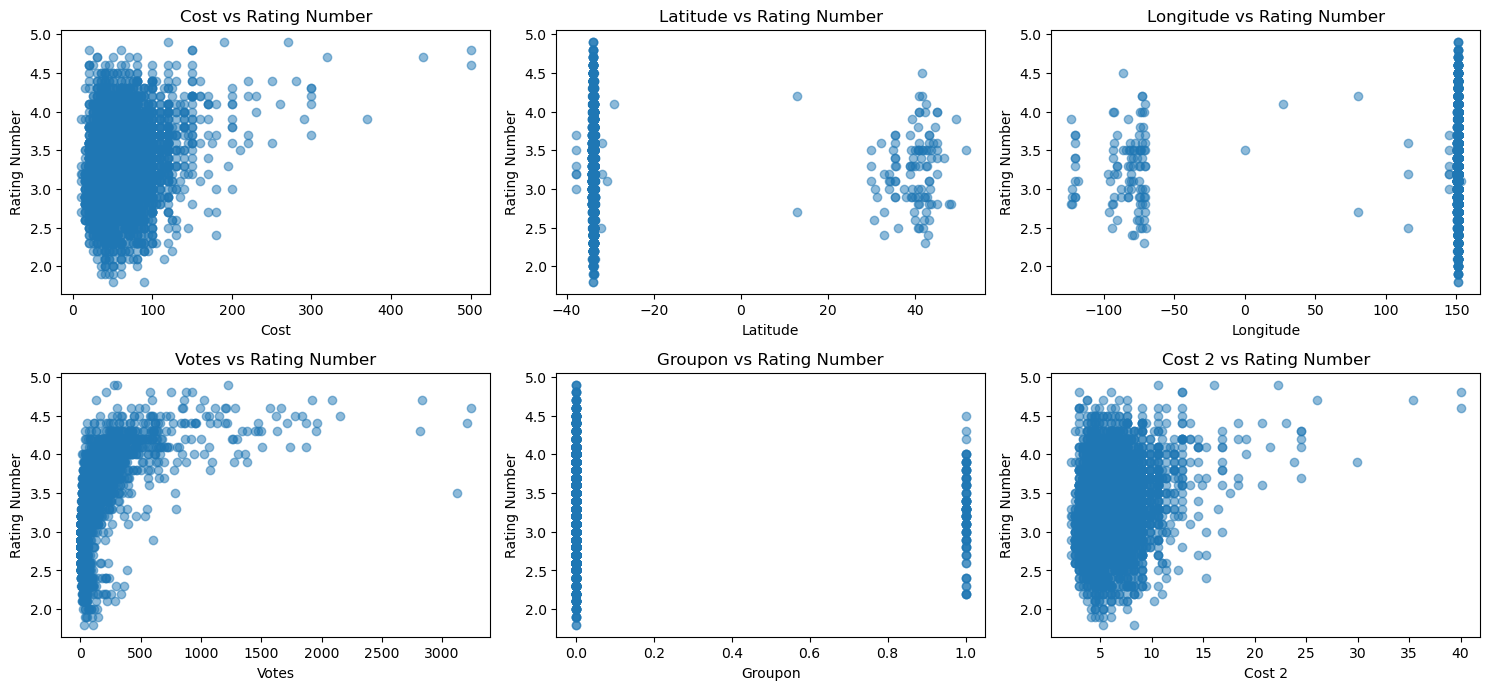

In [44]:

plt.figure(figsize=(15, 10))

# Scatter plot for 'cost' vs 'rating_number'
plt.subplot(3, 3, 1)
plt.scatter(df['cost'], df['rating_number'], alpha=0.5)
plt.xlabel('Cost')
plt.ylabel('Rating Number')
plt.title('Cost vs Rating Number')

# Scatter plot for 'lat' vs 'rating_number'
plt.subplot(3, 3, 2)
plt.scatter(df['lat'], df['rating_number'], alpha=0.5)
plt.xlabel('Latitude')
plt.ylabel('Rating Number')
plt.title('Latitude vs Rating Number')

# Scatter plot for 'lng' vs 'rating_number'
plt.subplot(3, 3, 3)
plt.scatter(df['lng'], df['rating_number'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Rating Number')
plt.title('Longitude vs Rating Number')

# Scatter plot for 'votes' vs 'rating_number'
plt.subplot(3, 3, 4)
plt.scatter(df['votes'], df['rating_number'], alpha=0.5)
plt.xlabel('Votes')
plt.ylabel('Rating Number')
plt.title('Votes vs Rating Number')

# Scatter plot for 'groupon' vs 'rating_number'
plt.subplot(3, 3, 5)
plt.scatter(df['groupon'], df['rating_number'], alpha=0.5)
plt.xlabel('Groupon')
plt.ylabel('Rating Number')
plt.title('Groupon vs Rating Number')

# Scatter plot for 'cost_2' vs 'rating_number'
plt.subplot(3, 3, 6)
plt.scatter(df['cost_2'], df['rating_number'], alpha=0.5)
plt.xlabel('Cost 2')
plt.ylabel('Rating Number')
plt.title('Cost 2 vs Rating Number')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

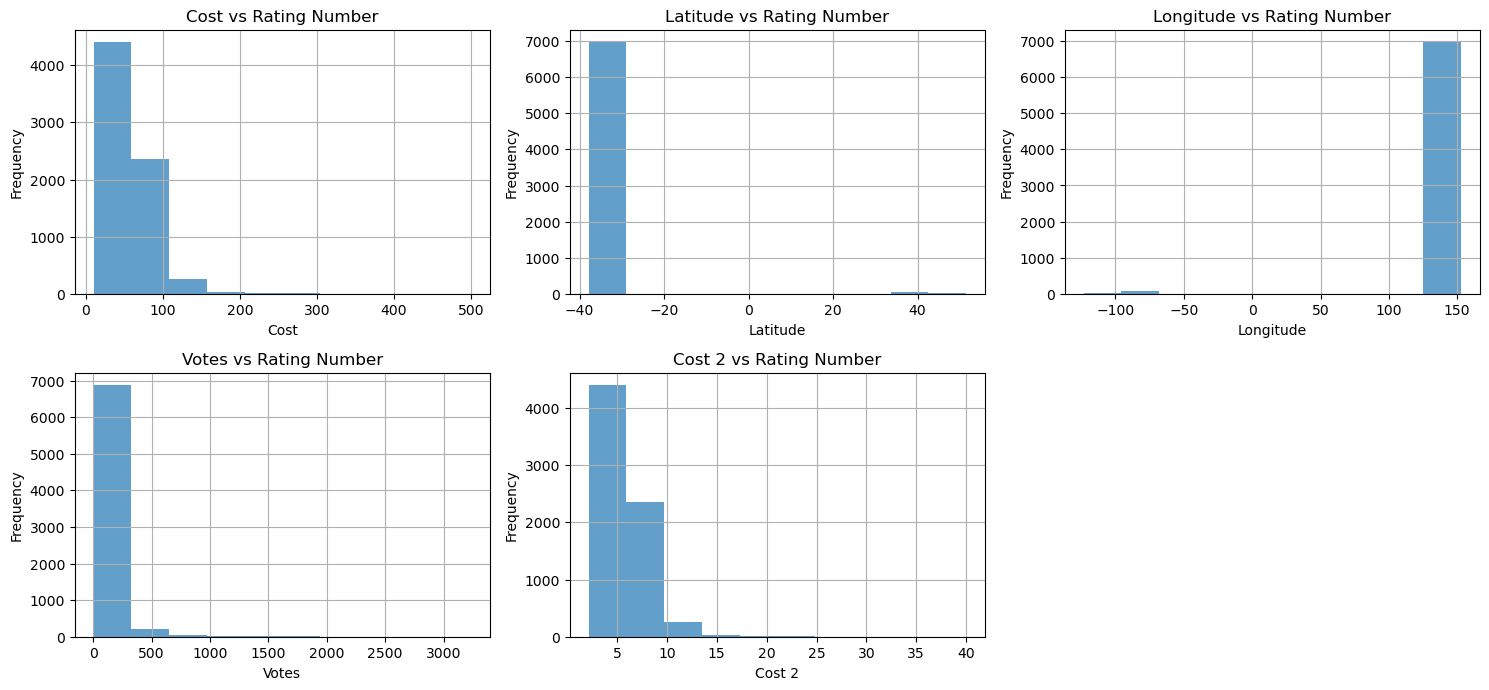

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Histogram for 'cost' vs 'rating_number'
plt.subplot(3, 3, 1)
df[df['rating_number'] > 0]['cost'].hist(bins=10, alpha=0.7)
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Cost vs Rating Number')

# Histogram for 'lat' vs 'rating_number'
plt.subplot(3, 3, 2)
df[df['rating_number'] > 0]['lat'].hist(bins=10, alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Latitude vs Rating Number')

# Histogram for 'lng' vs 'rating_number'
plt.subplot(3, 3, 3)
df[df['rating_number'] > 0]['lng'].hist(bins=10, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Longitude vs Rating Number')

# Histogram for 'votes' vs 'rating_number'
plt.subplot(3, 3, 4)
df[df['rating_number'] > 0]['votes'].hist(bins=10, alpha=0.7)
plt.xlabel('Votes')
plt.ylabel('Frequency')
plt.title('Votes vs Rating Number')

# Histogram for 'cost_2' vs 'rating_number'
plt.subplot(3, 3, 5)
df[df['rating_number'] > 0]['cost_2'].hist(bins=10, alpha=0.7)
plt.xlabel('Cost 2')
plt.ylabel('Frequency')
plt.title('Cost 2 vs Rating Number')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
# Find outliers in these variables
def find_outliers(variable, factor= 3, print_summary=True):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    Lower_boundary = df[variable].quantile(0.25) - (IQR * factor)
    Upper_boundary = df[variable].quantile(0.75) + (IQR * factor)
    
    outliers= []
    for index, val in enumerate(df[variable]):
        if val < Lower_boundary or val > Upper_boundary:
            outliers.append(index)
    
    
    if(print_summary):
        print('{variable} outliers are values < {lowerboundary} or > {upperboundary}'.format(variable= variable, lowerboundary=Lower_boundary, upperboundary=Upper_boundary))
    return Lower_boundary, Upper_boundary, outliers

In [47]:

_, _, cost_outliers = find_outliers('cost')



cost outliers are values < -60.0 or > 150.0


In [48]:

_, _, lat_outliers = find_outliers('lat')



lat outliers are values < -34.15602480000001 or > -33.55652029999999


In [49]:

_, _, lng_outliers = find_outliers('lng')


lng outliers are values < 150.61742475000003 or > 151.65257705


In [50]:

_, _, rating_outliers = find_outliers('rating_number')


rating_number outliers are values < 1.1999999999999997 or > 5.4


In [51]:
_, _, votes_outliers = find_outliers('votes')



votes outliers are values < -213.0 or > 312.0


In [52]:
_, _, cost_2_outliers = find_outliers('cost_2')

cost_2 outliers are values < -3.252032521 or > 12.967479676


- Outliers like 500,440,300, 270, etc. in cost represent restaurants with very high costs. Since these extreme values represent high-end restaurants, removing them may result in losing important insights about the expensive restaurants.

- Outliers in ‘lat’ and ‘lng’ represent some restaurants that are far from the main Sydney region.eg Blue mountain etc.

- Similarly outliers in votes represent more popular restaurants. 

These are the reasons we decided not to remove/ replace them with mean /median as they are important for the analysis

In [53]:
df.head()

address   cost  \
0                      371A Pitt Street, CBD, Sydney   50.0   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   80.0   
2   Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3   Sydney Opera House, Bennelong Point, Circular...  270.0   
4              20 Campbell Street, Chinatown, Sydney   55.0   

                                       cuisine        lat  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean'] -33.876059   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké'] -33.910999   
2                                 ['Japanese'] -33.867971   
3                        ['Modern Australian'] -33.856784   
4                            ['Thai', 'Salad'] -33.879035   

                                                link         lng  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  151.207605   
1  https://www.zomato.com/sydney/the-grounds-of-a...  151.193793   
2        https://www.zomato.com/sydney/sokyo-pyrmont  151.195210   
3  https://www.zomato.com/sydney/bennelong-restau...  151.215297   
4  https://www.zomato.com/sydney/chat-thai-chinatown  151.206409   

          phone  rating_number rating_text  \
0  02 8318 0406            4.0   Very Good   
1  02 9699 2225            4.6   Excellent   
2  1800 700 700            4.9   Excellent   
3  02 9240 8000            4.9   Excellent   
4  02 8317 4811            4.5   Excellent   

                                 subzone  ...                    type   votes  \
0                                    CBD  ...       ['Casual Dining']  1311.0   
1  The Grounds of Alexandria, Alexandria  ...                ['Café']  3236.0   
2                      The Star, Pyrmont  ...         ['Fine Dining']  1227.0   
3                          Circular Quay  ...  ['Fine Dining', 'Bar']   278.0   
4                              Chinatown  ...       ['Casual Dining']  2150.0   

   groupon    color     cost_2  cuisine_color  \
0    False  #e15307   5.243902        #6f706b   
1    False  #9c3203   7.560976        #6f706b   
2    False  #7f2704  10.650407        #6f706b   
3    False  #7f2704  22.235772        #4186f4   
4    False  #a83703   5.630081        #6f706b   

                              cuisine1               type1         suburb  \
0   [Hot Pot, Korean BBQ, BBQ, Korean]     [Casual Dining]            CBD   
1  [Cafe, Coffee and Tea, Salad, Poké]              [Café]     Alexandria   
2                           [Japanese]       [Fine Dining]        Pyrmont   
3                  [Modern Australian]  [Fine Dining, Bar]  Circular Quay   
4                        [Thai, Salad]     [Casual Dining]      Chinatown   

  cost_category  
0        Medium  
1          High  
2     Very High  
3     Expensive  
4          High  

[5 rows x 21 columns]

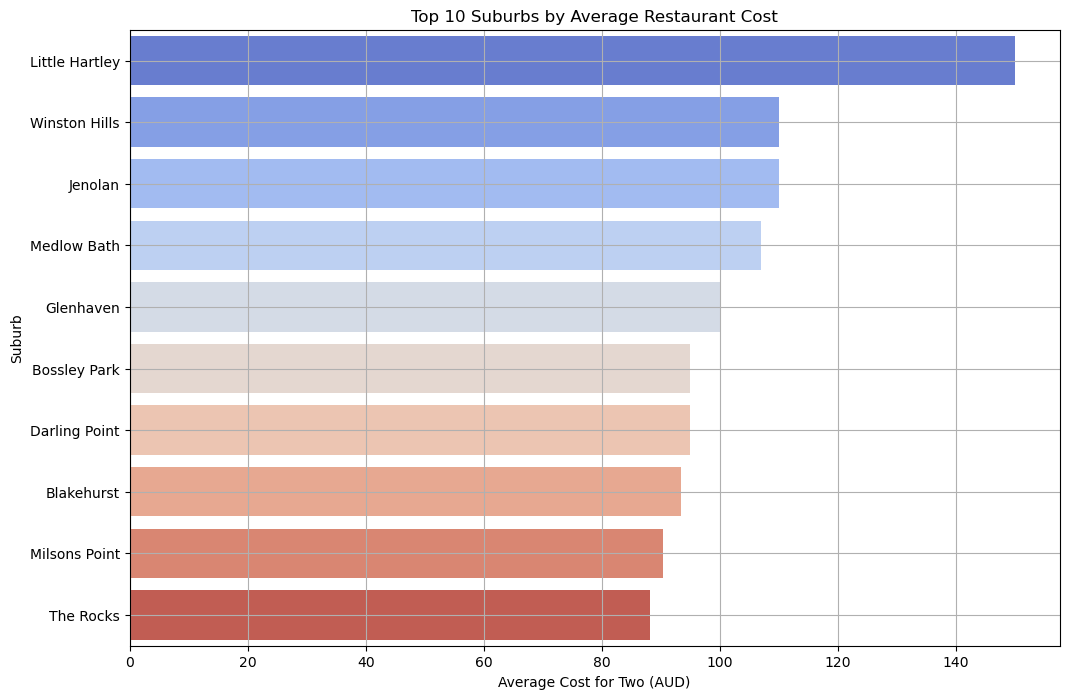

In [54]:
suburb_costs = df.groupby('suburb')['cost'].mean().sort_values(ascending=False).head(10)

# Plotting top 10 subzones by average restaurant cost
plt.figure(figsize=(12, 8))
sns.barplot(x=suburb_costs.values, y=suburb_costs.index, palette='coolwarm')
plt.title('Top 10 Suburbs by Average Restaurant Cost')
plt.xlabel('Average Cost for Two (AUD)')
plt.ylabel('Suburb')
plt.grid(True)
plt.show()

In [55]:
df_x = df.explode('cuisine1')

# Filter the dataset for 'Excellent' rated restaurants
excellent_rated_restaurants = df_x[df_x['rating_text'] == 'Excellent']

# Count the occurrences of each cuisine in 'Excellent' rated restaurants
excellent_rated_cuisine_counts = excellent_rated_restaurants['cuisine1'].value_counts()



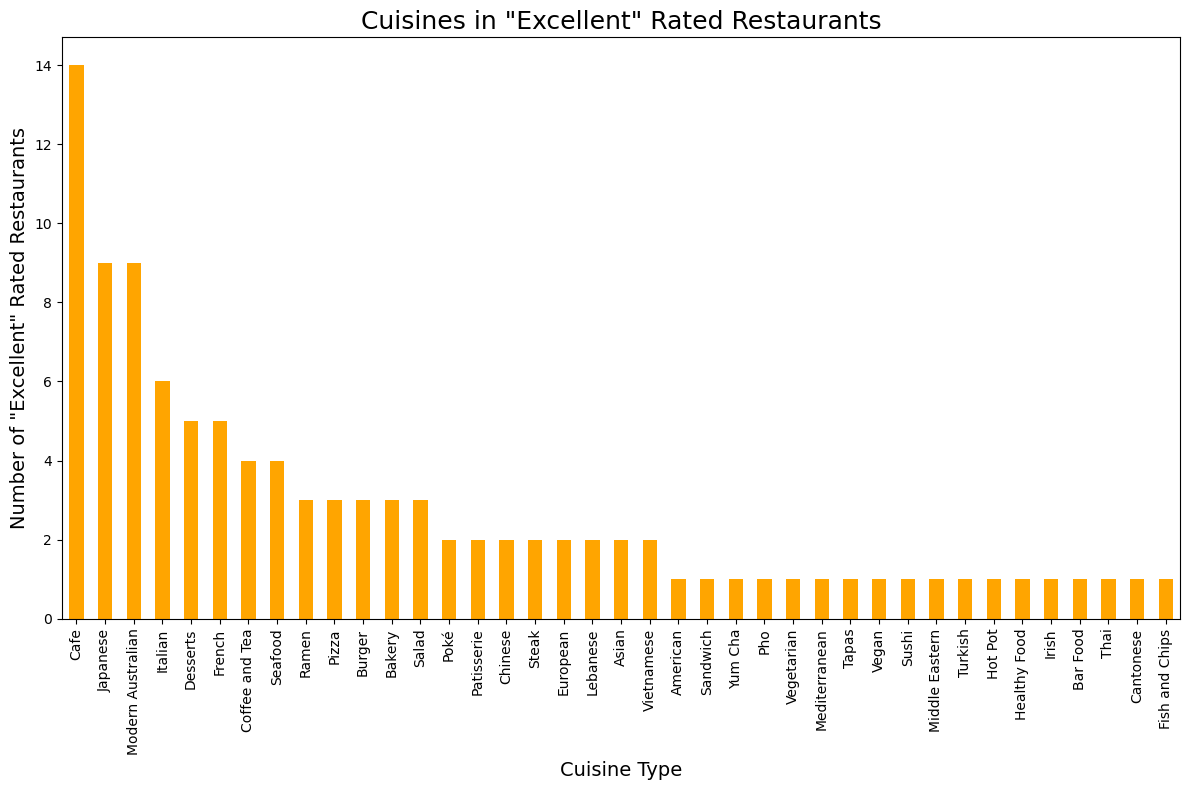

In [56]:
# Plot the bar chart for the cuisines in 'Excellent' rated restaurants
plt.figure(figsize=(12, 8))
excellent_rated_cuisine_counts.plot(kind='bar', color='orange')
plt.title('Cuisines in "Excellent" Rated Restaurants', fontsize=18)
plt.xlabel('Cuisine Type', fontsize=14)
plt.ylabel('Number of "Excellent" Rated Restaurants', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

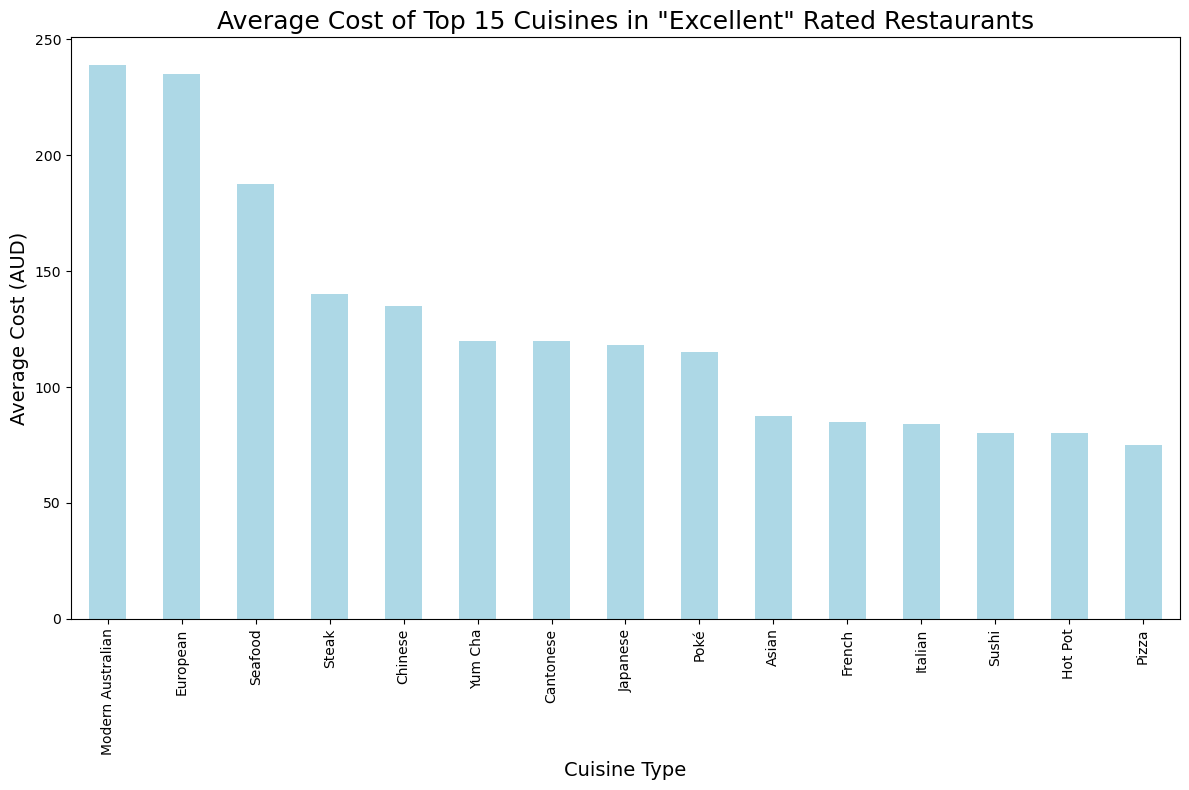

In [57]:
# Group by 'cuisine' and calculate the average cost for each cuisine in 'Excellent' rated restaurants
average_cost_per_cuisine = excellent_rated_restaurants.groupby('cuisine1')['cost'].mean().sort_values(ascending=False)

# Plot the bar chart for the average cost of the top 15 cuisines in 'Excellent' rated restaurants
plt.figure(figsize=(12, 8))
average_cost_per_cuisine.head(15).plot(kind='bar', color='lightblue')
plt.title('Average Cost of Top 15 Cuisines in "Excellent" Rated Restaurants', fontsize=18)
plt.xlabel('Cuisine Type', fontsize=14)
plt.ylabel('Average Cost (AUD)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

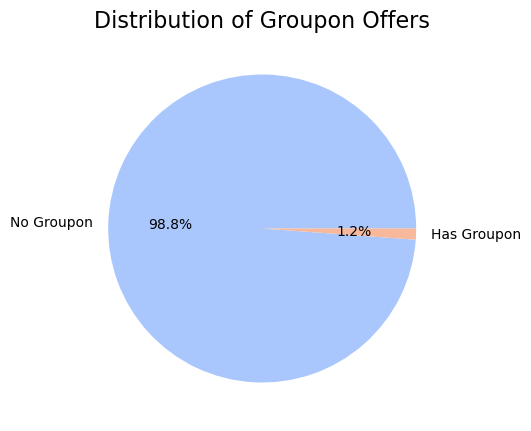

In [58]:
plt.figure(figsize=(5, 5))
df['groupon'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('coolwarm', 2), labels=['No Groupon', 'Has Groupon'])
plt.title('Distribution of Groupon Offers', fontsize=16)
plt.ylabel('')
plt.show()

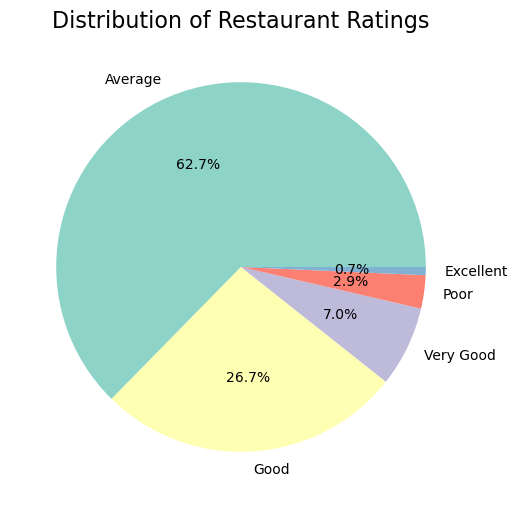

In [59]:
rating_counts = df['rating_text'].value_counts()
# Plot# pie chart for restaurant ratings
plt.figure(figsize=(6, 6))
df['rating_text'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set3', len(rating_counts)))
plt.title('Distribution of Restaurant Ratings', fontsize=16)
plt.ylabel('')
plt.show()

In [60]:
# Explode the 'type1' column to separate multiple restaurant types into individual rows
df_x = df.explode('type1')

# Filter the dataset for 'Excellent' rated restaurants
poor_rated_restaurants = df_x[df_x['rating_text'] == 'Poor']

# Count the occurrences of each restaurant type in 'Excellent' rated restaurants
poor_counts = poor_rated_restaurants['type1'].value_counts()



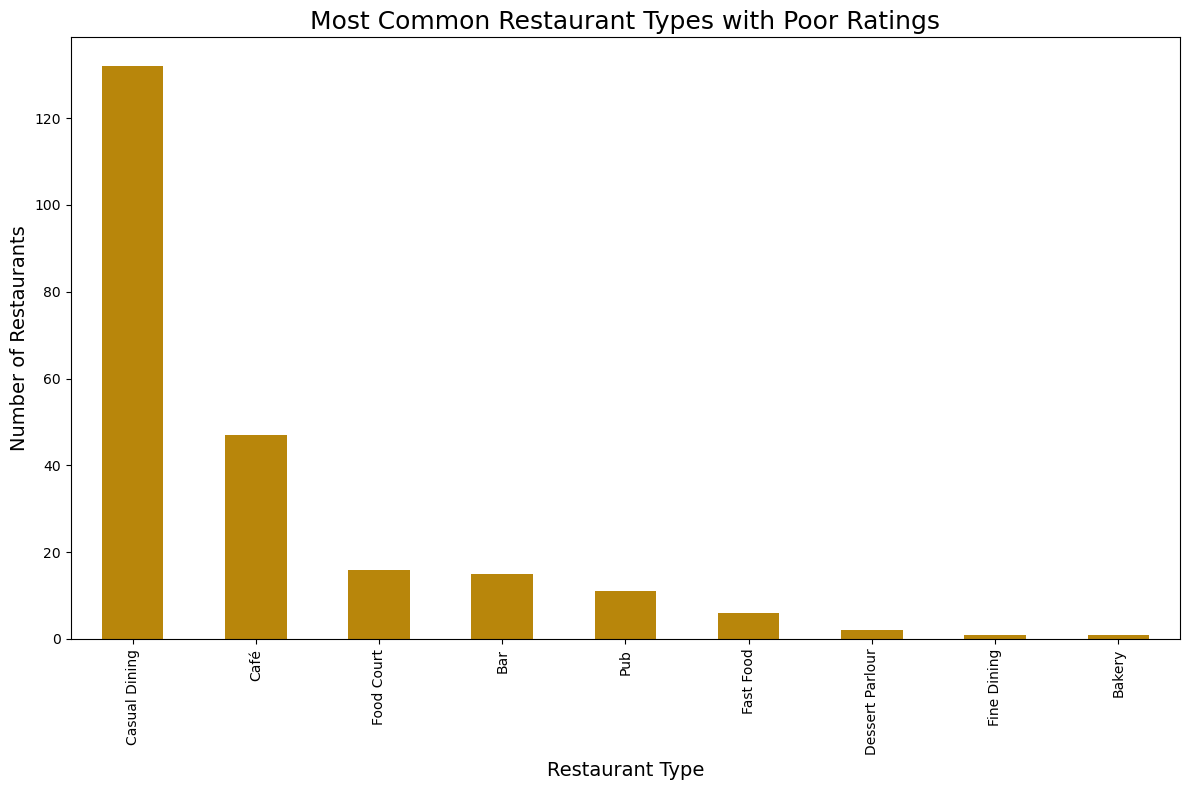

In [61]:
# Plot a bar chart for the most common restaurant types in 'poor' rated restaurants
plt.figure(figsize=(12, 8))
poor_counts.plot(kind='bar', color='#B8860B')
plt.title('Most Common Restaurant Types with Poor Ratings', fontsize=18)
plt.xlabel('Restaurant Type', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

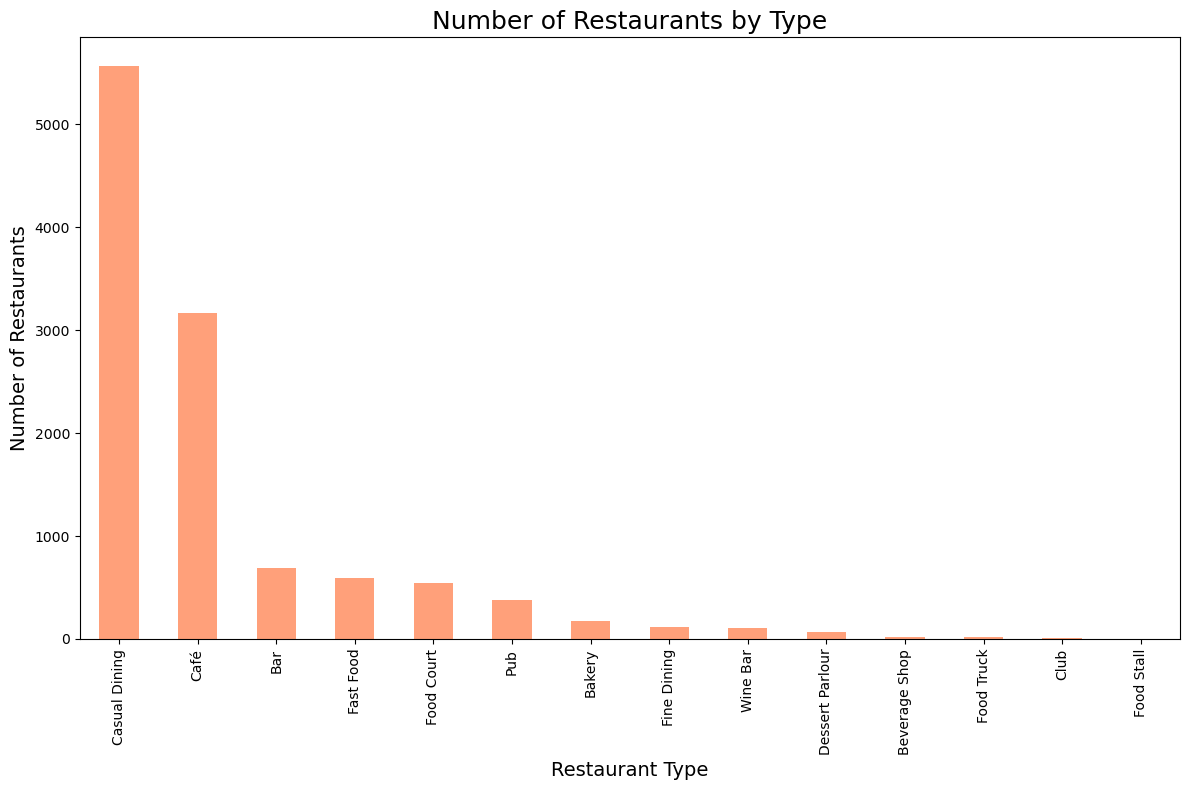

In [62]:
# plot the count of each restaurant type
plt.figure(figsize=(12, 8))
df_x['type1'].value_counts().plot(kind='bar', color='#FFA07A')
plt.title('Number of Restaurants by Type', fontsize=18)
plt.xlabel('Restaurant Type', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

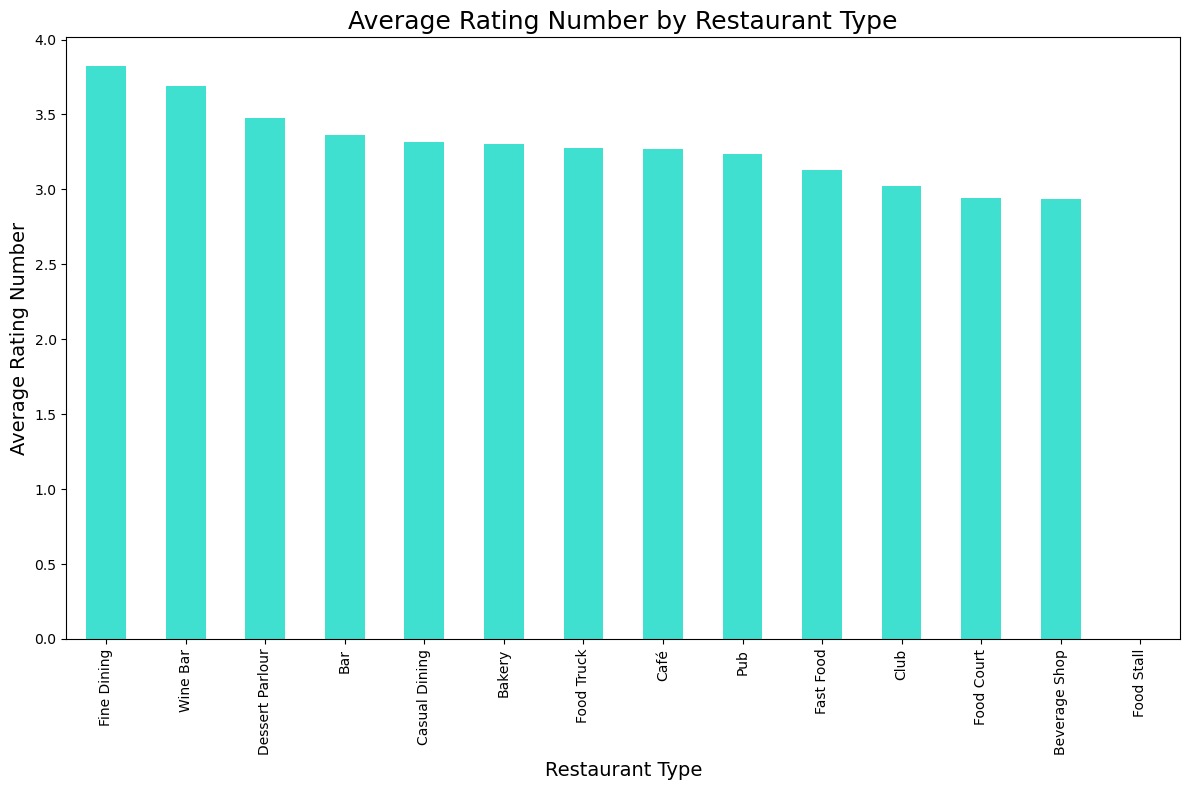

In [63]:
# Group by 'type1' and calculate the average rating number for each restaurant type
avg_rating_per_type = df_x.groupby('type1')['rating_number'].mean().sort_values(ascending=False)


# Plot the bar graphplt.figure(figsize=(14, 8))

plt.figure(figsize=(12, 8))
avg_rating_per_type.plot(kind='bar', color='#40E0D0')
plt.title('Average Rating Number by Restaurant Type', fontsize=18)
plt.xlabel('Restaurant Type', fontsize=14)
plt.ylabel('Average Rating Number', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- The remote suburbs like Little Hartley and Winston Hills attract wealthier customers as they have the highest average cost.
- Cuisines like Cafe,Modern Australian, Japanese,and Italian are most common in ‘Excellent’ rated restaurants. this proves that these cusines are like by more customers and their average cost of top cuisines is also higher than other cuisines.
- Casual dining, cafés, and food courts dominate the ‘Poor’ ratings
- Although Casual Dining and Café types appear in both high ratings as well , showing the difference in quality within these restaurant categories.

### Q3 : Cuisine Density Map

In [64]:
syd = gpd.read_file('~/Desktop/DST_Assignment/sydney.geojson')

In [65]:
def show_cuisine_densitymap(df, cuisine, syd):
    
    df_x = df.explode('cuisine1')

    # Filter restaurants for the selected cuisine
    filtered_restaurants = df_x[df_x['cuisine1'] == cuisine].dropna(subset=['lat', 'lng'])
    print(f"Number of restaurants serving {cuisine}: {len(filtered_restaurants)}")
    
    # Remove rows with missing lat/lng values
    filtered_restaurants = filtered_restaurants[filtered_restaurants['lat'].notnull() & filtered_restaurants['lng'].notnull()]
    
    # Convert restaurant lat/lng to point geometries
    gdf_restaurants = gpd.GeoDataFrame(filtered_restaurants,geometry=gpd.points_from_xy(filtered_restaurants.lng, filtered_restaurants.lat), crs="EPSG:4326")

    # Spatial join
    restaurants_in_suburbs = gpd.sjoin(gdf_restaurants, syd, predicate='within')

    # Count restaurants per suburb
    cuisine_density = restaurants_in_suburbs.groupby('SSC_NAME').agg(count=('SSC_NAME', 'size')).reset_index()
    # Merge back
    suburbs_cuisine_density = syd.merge(cuisine_density, how='left', left_on='SSC_NAME', right_on='SSC_NAME')

    # Fill NaN values  with 0
    suburbs_cuisine_density['count'] = suburbs_cuisine_density['count'].fillna(0)

    # Plot the cuisine density map
    plt.figure(figsize=(10, 10))
    suburbs_cuisine_density.plot(column='count', cmap='OrRd', legend=True, linewidth=0.8, edgecolor='black')
    plt.title(f'{cuisine} Restaurants Density Map in Sydney')
    plt.show()



Number of restaurants serving Indian: 395


<Figure size 1000x1000 with 0 Axes>

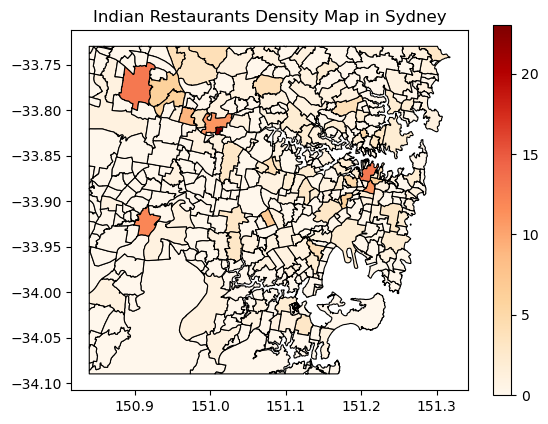

In [66]:
# Call the function 
show_cuisine_densitymap(df, 'Indian', syd)


Number of restaurants serving Chinese: 842


<Figure size 1000x1000 with 0 Axes>

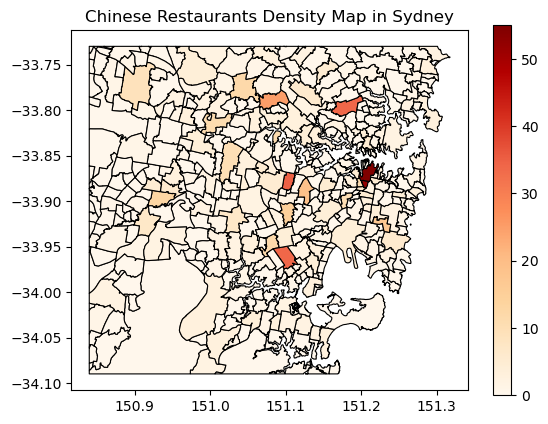

In [67]:
show_cuisine_densitymap(df, 'Chinese',syd)

Number of restaurants serving Steak: 102


<Figure size 1000x1000 with 0 Axes>

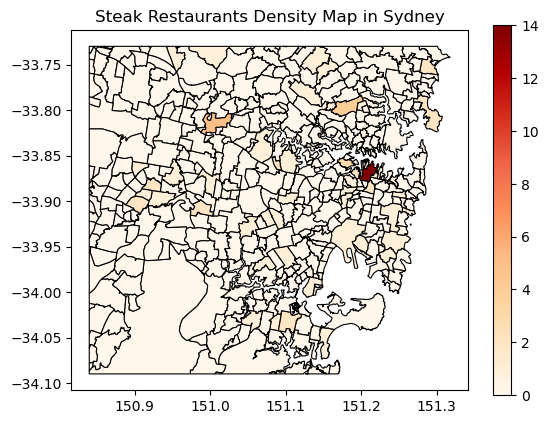

In [68]:
show_cuisine_densitymap(df, 'Steak',syd)

In [69]:



# Count the number of restaurants offering each cuisine
count = cusine.value_counts()

# Create a Plotly bar chart
fig = px.bar(
    x=count.index,  # Cuisine types (x-axis)
    y=count.values,  # Number of restaurants (y-axis)
    title='Number of Restaurants Offering Each Cuisine',
    labels={'x': 'Cuisine Type', 'y': 'Number of Restaurants'},  # Axis labels
    template='plotly_dark'
)

# Customize layout for better appearance
fig.update_layout(
    title_font_size=30,
    xaxis_title_font_size=20,
    yaxis_title_font_size=20,
    xaxis_tickangle=-90,  # Rotate x-axis labels for better readability
    xaxis_tickfont_size=15,
    yaxis_tickfont_size=15,
    height=800,
    width=3400
)

# Display the interactive plot
fig.show()

 - ***Limitation:*** We drew the same graph using matplotlib and we faced a challenge in visualisation as there are 134 different cuisine types. The static nature of the graph made it difficult to comprehend and analyze the data, especially due to the excess of x-axis labels. The axis labels were overlapping on each other, and it was hard to distinguish between different cuisine types. Additionally, it was very difficult to see individual cuisines or small sections of the graph.
 - ***Solution :*** But with plotly we can clearly see the data as it allows us to zoom and pan into any specific sections of the graph and we can focus on any part of the data. 
 - We can hover over each bar to see the exact count of restaurants offering each cuisine so we have better clarity.

In [70]:


# Data: Assume subzone_costs contains average restaurant costs by subzone
fig = px.bar(suburb_costs,
             x=suburb_costs.values, 
             y=suburb_costs.index,
             title="Top 10 suburbs by Average Restaurant Cost",
             labels={'x': 'Average Cost (AUD)', 'y': 'Subzone'},
             hover_name=suburb_costs.index,  # Display suburb names on hover
             hover_data={'Average Cost': suburb_costs.values})

# Make the bar chart interactive
fig.update_layout(
    xaxis_title="Average Cost for Two (AUD)",
    yaxis_title="Subzone",
    template="plotly_dark"
)

fig.show()

In [71]:
df = df.drop(columns=['cost_category','type1', 'cuisine1'])

In [72]:
print(f"The missing percentage of every column is " )
(df.isna().sum()/len(df))*100

The missing percentage of every column is 


address           0.000000
cost              3.295238
cuisine           0.000000
lat               1.828571
link              0.000000
lng               1.828571
phone             0.000000
rating_number    31.580952
rating_text      31.580952
subzone           0.000000
title             0.000000
type              0.457143
votes            31.580952
groupon           0.000000
color             0.000000
cost_2            3.295238
cuisine_color     0.000000
suburb            0.000000
dtype: float64

In [73]:
df.to_excel('df_tableau.xlsx', index=False)

# Part B

### Taking care of missing values

the missing values in the type column represent only 0.45% of the data, it is perfectly reasonable to simply drop those rows, 

In [74]:
df = df.dropna(subset=['type'])


In [75]:
df = df.dropna(subset = ['rating_number'])

In [76]:
#Group by 'type' and 'rating_text' and calculate the median cost
median_cost = df.groupby(['type', 'suburb'])['cost'].transform('median')

df['cost'] = df['cost'].fillna(median_cost)
df['cost'] = df['cost'].fillna(df.groupby('type')['cost'].transform('median'))

Here we are imputing the missing values by grouping them with different columns and then  imputing them by the median for the group.


In [77]:
df['cost_2'] = df['cost_2'].fillna(df.groupby(['type', 'suburb'])['cost_2'].transform('median'))
df['cost_2'] = df['cost_2'].fillna(df.groupby('type')['cost_2'].transform('median'))

In [78]:
df['lat'] = df['lat'].fillna(df.groupby('suburb')['lat'].transform('median'))
df['lat'] = df['lat'].fillna(df['lat'].median())

In [79]:
df['lng'] = df['lng'].fillna(df.groupby('suburb')['lng'].transform('median'))
df['lng'] = df['lng'].fillna(df['lng'].median())

The code first fills missing lat and lng values based on the suburb, and then fills any remaining missing values with the overall median of the lat column.

Check if any missing values left

In [80]:
df.isna().sum()

address          0
cost             0
cuisine          0
lat              0
link             0
lng              0
phone            0
rating_number    0
rating_text      0
subzone          0
title            0
type             0
votes            0
groupon          0
color            0
cost_2           0
cuisine_color    0
suburb           0
dtype: int64

## Encoding

In [81]:
df['suburb'].nunique()

336

following code cleans up the 'cuisine' and 'type' columns by removing unwanted characters, converting the text into lists, and then rejoining them as comma-separated strings.


In [82]:
# Clean 
df['cuisine1'] = df['cuisine'].str.strip("[]").str.replace("'", "").str.split(", ")
df['type1'] = df['type'].str.strip("[]").str.replace("'", "").str.split(", ")

df['cuisine2'] = df['cuisine1'].str.join(',')
df['type2'] = df['type1'].str.join(',')



In [83]:
# one-hot encoding
df_cus = df['cuisine2'].str.get_dummies(sep=',')
df_type = df['type2'].str.get_dummies(sep=',')

This code concatenates the DataFrame df (after dropping specified columns) with the cleaned df_cus and df_type DataFrames along the columns, creating a new DataFrame df1.



In [84]:
df1 = pd.concat([df.drop(columns=['cuisine', 'cuisine1', 'cuisine2', 'type', 'type1', 'type2', 'address', 'link', 'phone', 'color', 'cuisine_color','suburb','subzone', 'title','cost_2']), df_cus, df_type] , axis=1)

This code adds a new column rating to the DataFrame df1 by converting the values in the rating_text column into numeric ratings, with 'Poor' and 'Average' assigned a value of 1, and 'Good', 'Very Good', and 'Excellent' assigned a value of 2.


In [85]:
df1['rating'] = df1['rating_text'].map({
    'Poor': 1,
    'Average': 1,
    'Good': 2,
    'Very Good': 2,
    'Excellent': 2
})

In [86]:
df1.shape

(7163, 149)

In [87]:
# Drop irrelevant columns from the dataset
df1 = df1.drop(columns=['rating_text' ])

In [88]:
categorical_columns = df1.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index([], dtype='object')


In [89]:
df1.shape

(7163, 148)

In [90]:
df1.isna().sum()

cost             0
lat              0
lng              0
rating_number    0
votes            0
                ..
Food Court       0
Food Truck       0
Pub              0
Wine Bar         0
rating           0
Length: 148, dtype: int64

## Dimensionality Reduction (PCA)

In [91]:
np.random.seed(42)

In [92]:
X = df1.drop(columns=['rating_number', 'rating'])  # Drop the target variable
y = df1['rating_number']  

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
pca = PCA(n_components=115)
X_pca = pca.fit_transform(X_scaled)


 This code effectively prepares the dataset for further analysis by scaling the features and reducing their dimensionality using PCA.
Now we chose to keep 80 % of the values because 95% components were causing the models to overfit .

## Linear Regression

Following code trains a linear regression and and gradient descent linear regression. and check out thwe MSE.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

In [96]:
model_regression_1 = LinearRegression()

In [97]:
model_regression_1.fit(X_train, y_train)

LinearRegression()

In [98]:
# Predictions with  Linear Regression
y_train_pred_1 = model_regression_1.predict(X_train)
y_test_pred_1 = model_regression_1.predict(X_test)

In [99]:
# Calculate MSE for both training and testing data
mse_train_1 = mean_squared_error(y_train, y_train_pred_1)
mse_test_1 = mean_squared_error(y_test, y_test_pred_1)

In [100]:
print("\n**********************Linear Regression*****************************\n")
print(f'MSE on Training Set (model_regression_1): {mse_train_1}')
print(f'MSE on Test Set (model_regression_1): {mse_test_1}')



**********************Linear Regression*****************************

MSE on Training Set (model_regression_1): 0.14563008794829968
MSE on Test Set (model_regression_1): 0.15504351136893696


## Gradient Descent

In [101]:
# Build the SGD-based Linear Regression model
model_regression_2 = SGDRegressor(
    loss='squared_error', 
    max_iter=1000, 
    tol=1e-3, 
    eta0=0.001,  
    alpha=0.0001  
)

In [102]:
model_regression_2.fit(X_train, y_train)

SGDRegressor(eta0=0.001)

In [103]:
# Predict
y_train_pred_2 = model_regression_2.predict(X_train)
y_test_pred_2 = model_regression_2.predict(X_test)

In [104]:
# calculate MSE
mse_train_2 = mean_squared_error(y_train, y_train_pred_2)
mse_test_2 = mean_squared_error(y_test, y_test_pred_2)

In [105]:
print("\n**********************Linear Regression(Gradient Descent)*****************************\n")
print(f'MSE on Training Set (model_regression_2): {mse_train_2}')
print(f'MSE on Test Set (model_regression_2): {mse_test_2}')



**********************Linear Regression(Gradient Descent)*****************************

MSE on Training Set (model_regression_2): 0.14571244178096687
MSE on Test Set (model_regression_2): 0.1639286927679326


In [106]:
regression_results = {
    'Model': ['Linear Regression', 'Linear Regression (Gradient Descent)'],
    'MSE (Training Set)': [mse_train_1, mse_train_2],
    'MSE (Test Set)': [mse_test_1, mse_test_2]
}

# Create the DataFrame
df_results = pd.DataFrame(regression_results)

# Print the DataFrame
print("\n************************** Results **************************\n")
print(df_results.to_string(index=False))


************************** Results **************************

                               Model  MSE (Training Set)  MSE (Test Set)
                   Linear Regression            0.145630        0.155044
Linear Regression (Gradient Descent)            0.145712        0.163929


- The difference between the training set MSE (0.15) and the test set MSE (0.16) for the linear regression model is fairly small. This indicates that our model is not overfitting, as the performance on the training data is very close to that on the unseen test data.

- Similarly for Linear model with the Gradient Descent the MSE difference is again very small. 

- MSE of around 0.01 suggests that the model’s predictions are extreemely close to the true values, meaning the model is performing decently.
- So both our models are working good.

## Classification 

Now we will start classification process. We are using Logistic regression, Decision Trees, Random Forests, KNN, SVM. 

In [107]:
df1['rating'].value_counts()

rating
1    4695
2    2468
Name: count, dtype: int64

In [108]:
X = X_scaled 
y = df1['rating']  # Binary target variable


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [110]:
# intiate the model
model_classification_3 = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
model_classification_3.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [111]:
y_pred = model_classification_3.predict(X_test)

In [112]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8444


In [113]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(conf_matrix)



Confusion Matrix:
[[859  59]
 [164 351]]


In [114]:
#Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[859  59]
 [164 351]]

True Positives(TP) =  859

True Negatives(TN) =  351

False Positives(FP) =  59

False Negatives(FN) =  164


<Axes: >

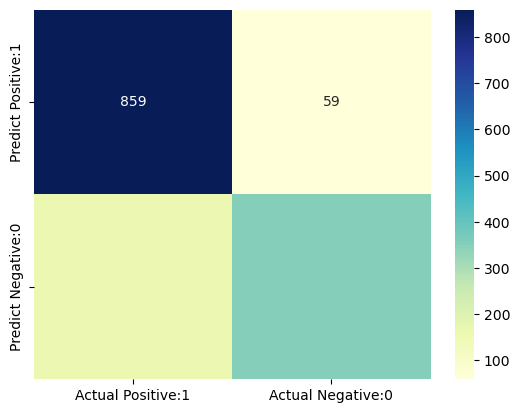

In [115]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Visualise Confusion Matrix

<Axes: >

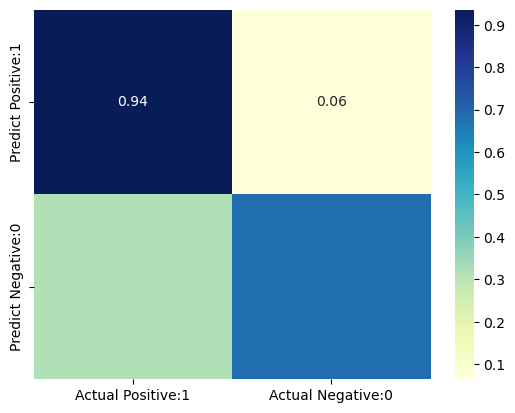

In [116]:
cm_normalised = cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm_normalised, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='.2f', cmap='YlGnBu')

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.94      0.89       918
           2       0.86      0.68      0.76       515

    accuracy                           0.84      1433
   macro avg       0.85      0.81      0.82      1433
weighted avg       0.85      0.84      0.84      1433



Following code makes a grid of classifiers and then applies them on the data. 

In [118]:


classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=14, min_samples_split=10,  class_weight='balanced'),
    "SVM": SVC(C=1.0, kernel='linear', gamma='scale', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=6)
}

In [119]:
# Iterate through the classifiers and fit each model
for name, clf in classifiers.items():
    print(f"\n********** {name} **********")
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Evaluate the accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Classification report
    report = classification_report(y_test, y_test_pred)
    
    # Print results
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Classification Report: \n{report}")


********** Logistic Regression **********
Train Accuracy: 0.8642233856893543
Test Accuracy: 0.8604326587578507
Classification Report: 
              precision    recall  f1-score   support

           1       0.89      0.89      0.89       918
           2       0.81      0.80      0.80       515

    accuracy                           0.86      1433
   macro avg       0.85      0.85      0.85      1433
weighted avg       0.86      0.86      0.86      1433


********** Random Forest **********
Train Accuracy: 0.8568935427574171
Test Accuracy: 0.8695045359385903
Classification Report: 
              precision    recall  f1-score   support

           1       0.94      0.85      0.89       918
           2       0.77      0.90      0.83       515

    accuracy                           0.87      1433
   macro avg       0.86      0.88      0.86      1433
weighted avg       0.88      0.87      0.87      1433


********** Decision Tree **********
Train Accuracy: 0.912565445026178
Test Accu

# Model Observations and Conclusion

### Logistic Regression:
  - **Train Accuracy**: 86.42%
  - **Test Accuracy**: 86.04%
  - **Precision, Recall, F1-Score**:
    - Class 1: Precision 0.89, Recall 0.89, F1-Score 0.89
    - Class 2: Precision 0.81, Recall 0.80, F1-Score 0.80
  - **Observation**:
    - The model shows perform consistentently on both training and test sets, with balanced .
    - The precision and recall for both classes are very balance showing that Logistic Regression is well-suited for this problem.
  
### Random Forest:
  - **Train Accuracy**: 85.69%
  - **Test Accuracy**: 86.95%
  - **Precision, Recall, F1-Score**:
    - Class 1: Precision 0.94, Recall 0.85, F1-Score 0.89
    - Class 2: Precision 0.77, Recall 0.90, F1-Score 0.83
  - **Observation**:
    - Random Forest shows good test accuracy.
    - The high precision for Class 1 and high recall for Class 2 indicates that the model handles different classes effectively, particularly excelling in detecting class 2.
    - But the precision and recall are not very balanced.
  
### Decision Tree**:
  - **Train Accuracy**: 91.26%
  - **Test Accuracy**: 84.09%
  - **Precision, Recall, F1-Score**:
    - Class 1: Precision 0.90, Recall 0.84, F1-Score 0.87
    - Class 2: Precision 0.75, Recall 0.83, F1-Score 0.79
  - **Observation**:
    - Decision Tree shows signs of overfitting, as the train accuracy is significantly higher than the test accuracy.
    - Precision and recall are also very unbalanced, the model doesn't generalize as well as others, likely due to its tendency to overfit to the training data.

### Support Vector Machine (SVM)**:
  - **Train Accuracy**: 86.91%
  - **Test Accuracy**: 86.67%
  - **Precision, Recall, F1-Score**:
    - Class 1: Precision 0.90, Recall 0.89, F1-Score 0.90
    - Class 2: Precision 0.81, Recall 0.82, F1-Score 0.82
  - **Observation**:
    - SVM provides a well-balanced performance with consistent precision and recall for both classes.
    - It generalizes well, with train and test accuracies quite close to each other.
    - This model is a good choice for this dataset, offering good accuracy and performance.

### K-Nearest Neighbors (KNN)**:
  - **Train Accuracy**: 81.54%
  - **Test Accuracy**: 76.83%
  - **Precision, Recall, F1-Score**:
    - Class 1: Precision 0.76, Recall 0.94, F1-Score 0.84
    - Class 2: Precision 0.81, Recall 0.47, F1-Score 0.59
  - **Observation**:
    - KNN struggles to classify class 2 accurately, with low recall leading to a poor F1-score for this class.

## Conclusion
- **Best Model**: Random Forest and SVM are the best performing models based on overall accuracy and balanced performance across both classes.
- **Overfitting Concern**: Decision Tree shows overfitting, and while it performs reasonably well, it is less reliable than others. 
- Further Hyper parameter tuning can help make the models more generalized and effective. 